# 3D DEEP LEARNING

## Imports

In [1]:
!pip install open3d

In [10]:
import os
import random
from random import randrange
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from datasets import PartDataset
#from pointnet import PointNetCls
import torch.nn.functional as F
import matplotlib.pyplot as plt
import open3d as o3
#import download
from open3d import JVisualizer
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

# Dataset

We are going to work with the ShapeNet Dataset.
It's coming from Standford and will allow us to do both Classification and Segmentation.

In [11]:
#Run this only if you don't already have the Dataset
!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip

  Issued certificate has expired.
2021-02-16 11:45:10 URL:https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip [666265910/666265910] -> "shapenetcore_partanno_segmentation_benchmark_v0.zip" [1]
Archive:  shapenetcore_partanno_segmentation_benchmark_v0.zip
replace shapenetcore_partanno_segmentation_benchmark_v0/02954340/seg_img/e823673c1edd73fb97c426435543a860.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = DATA_FOLDER = './shapenetcore_partanno_segmentation_benchmark_v0'


In [2]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import torch
import json
import codecs
import numpy as np
import progressbar
import sys
import torchvision.transforms as transforms
import argparse
import json
import open3d


class PartDataset(data.Dataset):
    def __init__(self, root, npoints = 2500, classification = False, class_choice = None, train = True):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}

        self.classification = classification

        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}

        self.meta = {}
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            #print(dir_point, dir_seg)
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            #print(os.path.basename(fns))
            for fn in fns:
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg')))

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1]))


        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        print(self.classes)
        self.num_seg_classes = 0
        if not self.classification:
            for i in range(len(self.datapath)//50):
                l = len(np.unique(np.loadtxt(self.datapath[i][-1]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)


    def __getitem__(self, index):
        fn = self.datapath[index]
        cls = self.classes[self.datapath[index][0]]
        point_set = np.asarray(
            open3d.io.read_point_cloud(fn[1], format='xyz').points,
            dtype=np.float32)
        seg = np.loadtxt(fn[2]).astype(np.int64)
        #print(point_set.shape, seg.shape)

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        #resample
        point_set = point_set[choice, :]
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        if self.classification:
            return point_set, cls
        else:
            return point_set, seg

    def __len__(self):
        return len(self.datapath)

test
{'Chair': 0}
3371
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
15990
torch.Size([2500, 3]) torch.FloatTensor torch.Size([1]) torch.LongTensor


In [6]:
# Create dataset object
test_dataset_seg = PartDataset(
    root=DATA_FOLDER,
    train=False,
    classification=False,
    npoints=NUM_POINTS)

# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}


## Visualize the Dataset with Open3D

In [28]:
d = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', class_choice = ['Airplane'])
print(len(d))
import random
ps, seg = random.choice(d)
print(ps.size(), ps.type(), seg.size(),seg.type())

'''
d = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True)
print(len(d))
ps, cls = d[0]
print(ps.size(), ps.type(), cls.size(),cls.type())
'''

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
15990
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor


"\nd = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True)\nprint(len(d))\nps, cls = d[0]\nprint(ps.size(), ps.type(), cls.size(),cls.type())\n"

In [17]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [29]:
test_vis = JVisualizer()
test_vis.clear()
clear_output()
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

test_vis.add_geometry(test_cloud)
test_vis.show()

JVisualizer with 1 geometries

# 3D Deep Learning Model

## Build the Model

In [36]:
class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d()
out = trans(sim_data)
print('stn', out.size())

stn torch.Size([32, 3, 3])


In [31]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
        
    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [37]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1024])


In [32]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1), trans

In [38]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k = 5)
out, _ = cls(sim_data)
print('class', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


In [33]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, self.num_points, self.k)
        return x, trans

In [39]:
seg = PointNetDenseCls(k = 3)
out, _ = seg(sim_data)
print('seg', out.size())

seg torch.Size([32, 2500, 3])


In [42]:
print(len(classes_dict.items()))

16


## Train the Model for classification and segmentation

In [50]:
batchSize = 32
num_points = 2500
workers = 4
nepoch = 25
outf="cls"

In [55]:
# DATASET & DATA LOADER
dataset = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True, npoints = num_points)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

test_dataset = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True, train = False, npoints = num_points)
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,shuffle=True, num_workers=workers)

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())
classifier = PointNetCls(k = num_classes, num_points = num_points)
#classifier.load_state_dict(torch.load(""))

# DEFINE OPTIMIZERS
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)/batchSize

# TRAIN ON EPOCHS
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        points, target = data
        points, target = Variable(points), Variable(target[:,0])
        points = points.transpose(2,1)
        if torch.cuda.is_available():
            points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, _ = classifier(points)
        loss = F.nll_loss(pred, target)
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, loss.item(),correct.item() / float(batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            points, target = Variable(points), Variable(target[:,0])
            points = points.transpose(2,1)
            if torch.cuda.is_available():
                points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch))

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
[0: 0/499] train loss: 2.811898 accuracy: 0.031250
[0: 0/499] test loss: 2.758509 accuracy: 0.031250
[0: 1/499] train loss: 2.772773 accuracy: 0.156250
[0: 2/499] train loss: 2.092318 accuracy: 0.562500
[0: 3/499] train loss: 1.919288 accuracy: 0.625000
[0: 4/499] train loss: 1.464674 accuracy: 0.718750
[0: 5/499] train loss: 1.358144 accuracy: 0.718750
[0: 6/499] train loss: 0.945803 accuracy: 0.781250
[0: 7/499] train loss: 0.868699 accuracy: 0.812500
[0: 8/499] train loss: 0.473060 accuracy: 0.937500
[0: 9/499] train loss: 0.721222 accuracy: 0.843750
[0: 10/499] train loss

[0: 133/499] train loss: 0.346179 accuracy: 0.906250
[0: 134/499] train loss: 0.232819 accuracy: 0.875000
[0: 135/499] train loss: 0.543591 accuracy: 0.843750
[0: 136/499] train loss: 0.215936 accuracy: 0.968750
[0: 137/499] train loss: 0.358993 accuracy: 0.875000
[0: 138/499] train loss: 0.193040 accuracy: 0.937500
[0: 139/499] train loss: 0.257632 accuracy: 0.937500
[0: 140/499] train loss: 0.544990 accuracy: 0.875000
[0: 140/499] test loss: 0.351708 accuracy: 0.906250
[0: 141/499] train loss: 0.253314 accuracy: 0.906250
[0: 142/499] train loss: 0.280004 accuracy: 0.906250
[0: 143/499] train loss: 0.161924 accuracy: 0.937500
[0: 144/499] train loss: 0.143302 accuracy: 0.937500
[0: 145/499] train loss: 0.145386 accuracy: 0.937500
[0: 146/499] train loss: 0.111803 accuracy: 0.968750
[0: 147/499] train loss: 0.142283 accuracy: 0.906250
[0: 148/499] train loss: 0.148761 accuracy: 0.937500
[0: 149/499] train loss: 0.158908 accuracy: 0.937500
[0: 150/499] train loss: 0.325102 accuracy: 0.9

[0: 273/499] train loss: 0.067987 accuracy: 0.968750
[0: 274/499] train loss: 0.428172 accuracy: 0.906250
[0: 275/499] train loss: 0.116141 accuracy: 0.968750
[0: 276/499] train loss: 0.060413 accuracy: 1.000000
[0: 277/499] train loss: 0.150830 accuracy: 0.937500
[0: 278/499] train loss: 0.306433 accuracy: 0.906250
[0: 279/499] train loss: 0.200595 accuracy: 0.937500
[0: 280/499] train loss: 0.164518 accuracy: 0.968750
[0: 280/499] test loss: 0.011022 accuracy: 1.000000
[0: 281/499] train loss: 0.082950 accuracy: 0.968750
[0: 282/499] train loss: 0.047679 accuracy: 1.000000
[0: 283/499] train loss: 0.413928 accuracy: 0.937500
[0: 284/499] train loss: 0.203678 accuracy: 0.937500
[0: 285/499] train loss: 0.338821 accuracy: 0.906250
[0: 286/499] train loss: 0.145402 accuracy: 0.937500
[0: 287/499] train loss: 0.055277 accuracy: 1.000000
[0: 288/499] train loss: 0.085555 accuracy: 0.968750
[0: 289/499] train loss: 0.180971 accuracy: 0.937500
[0: 290/499] train loss: 0.143095 accuracy: 0.9

[0: 413/499] train loss: 0.147422 accuracy: 0.968750
[0: 414/499] train loss: 0.046533 accuracy: 1.000000
[0: 415/499] train loss: 0.016164 accuracy: 1.000000
[0: 416/499] train loss: 0.078253 accuracy: 0.968750
[0: 417/499] train loss: 0.118517 accuracy: 0.968750
[0: 418/499] train loss: 0.057643 accuracy: 1.000000
[0: 419/499] train loss: 0.119003 accuracy: 0.968750
[0: 420/499] train loss: 0.171383 accuracy: 0.968750
[0: 420/499] test loss: 0.172953 accuracy: 0.937500
[0: 421/499] train loss: 0.187723 accuracy: 0.968750
[0: 422/499] train loss: 0.013087 accuracy: 1.000000
[0: 423/499] train loss: 0.058339 accuracy: 0.968750
[0: 424/499] train loss: 0.123966 accuracy: 0.937500
[0: 425/499] train loss: 0.318372 accuracy: 0.875000
[0: 426/499] train loss: 0.317430 accuracy: 0.906250
[0: 427/499] train loss: 0.023243 accuracy: 1.000000
[0: 428/499] train loss: 0.146202 accuracy: 0.937500
[0: 429/499] train loss: 0.112238 accuracy: 0.968750
[0: 430/499] train loss: 0.087572 accuracy: 0.9

[1: 53/499] train loss: 0.117441 accuracy: 0.937500
[1: 54/499] train loss: 0.059869 accuracy: 1.000000
[1: 55/499] train loss: 0.165114 accuracy: 0.906250
[1: 56/499] train loss: 0.143854 accuracy: 0.968750
[1: 57/499] train loss: 0.113094 accuracy: 0.968750
[1: 58/499] train loss: 0.117285 accuracy: 0.906250
[1: 59/499] train loss: 0.406945 accuracy: 0.906250
[1: 60/499] train loss: 0.367496 accuracy: 0.906250
[1: 60/499] test loss: 0.037473 accuracy: 1.000000
[1: 61/499] train loss: 0.033197 accuracy: 1.000000
[1: 62/499] train loss: 0.099876 accuracy: 0.968750
[1: 63/499] train loss: 0.043841 accuracy: 1.000000
[1: 64/499] train loss: 0.089495 accuracy: 0.937500
[1: 65/499] train loss: 0.216835 accuracy: 0.937500
[1: 66/499] train loss: 0.079373 accuracy: 0.968750
[1: 67/499] train loss: 0.164501 accuracy: 0.906250
[1: 68/499] train loss: 0.052211 accuracy: 1.000000
[1: 69/499] train loss: 0.263049 accuracy: 0.937500
[1: 70/499] train loss: 0.076783 accuracy: 0.968750
[1: 70/499] t

[1: 193/499] train loss: 0.299942 accuracy: 0.937500
[1: 194/499] train loss: 0.008597 accuracy: 1.000000
[1: 195/499] train loss: 0.021445 accuracy: 1.000000
[1: 196/499] train loss: 0.014334 accuracy: 1.000000
[1: 197/499] train loss: 0.113955 accuracy: 0.937500
[1: 198/499] train loss: 0.041167 accuracy: 1.000000
[1: 199/499] train loss: 0.008771 accuracy: 1.000000
[1: 200/499] train loss: 0.247767 accuracy: 0.937500
[1: 200/499] test loss: 0.009690 accuracy: 1.000000
[1: 201/499] train loss: 0.270019 accuracy: 0.968750
[1: 202/499] train loss: 0.017780 accuracy: 1.000000
[1: 203/499] train loss: 0.060457 accuracy: 1.000000
[1: 204/499] train loss: 0.079282 accuracy: 0.968750
[1: 205/499] train loss: 0.085939 accuracy: 0.968750
[1: 206/499] train loss: 0.077855 accuracy: 1.000000
[1: 207/499] train loss: 0.149574 accuracy: 0.968750
[1: 208/499] train loss: 0.048617 accuracy: 1.000000
[1: 209/499] train loss: 0.004982 accuracy: 1.000000
[1: 210/499] train loss: 0.015323 accuracy: 1.0

[1: 333/499] train loss: 0.021256 accuracy: 1.000000
[1: 334/499] train loss: 0.012178 accuracy: 1.000000
[1: 335/499] train loss: 0.201873 accuracy: 0.968750
[1: 336/499] train loss: 0.008530 accuracy: 1.000000
[1: 337/499] train loss: 0.072169 accuracy: 0.968750
[1: 338/499] train loss: 0.085769 accuracy: 0.968750
[1: 339/499] train loss: 0.076084 accuracy: 0.968750
[1: 340/499] train loss: 0.010040 accuracy: 1.000000
[1: 340/499] test loss: 0.070744 accuracy: 0.968750
[1: 341/499] train loss: 0.012797 accuracy: 1.000000
[1: 342/499] train loss: 0.010062 accuracy: 1.000000
[1: 343/499] train loss: 0.229787 accuracy: 0.968750
[1: 344/499] train loss: 0.072550 accuracy: 0.968750
[1: 345/499] train loss: 0.079211 accuracy: 0.968750
[1: 346/499] train loss: 0.004344 accuracy: 1.000000
[1: 347/499] train loss: 0.235240 accuracy: 0.968750
[1: 348/499] train loss: 0.259329 accuracy: 0.937500
[1: 349/499] train loss: 0.151516 accuracy: 0.968750
[1: 350/499] train loss: 0.073106 accuracy: 0.9

[1: 473/499] train loss: 0.190584 accuracy: 0.937500
[1: 474/499] train loss: 0.013330 accuracy: 1.000000
[1: 475/499] train loss: 0.037681 accuracy: 1.000000
[1: 476/499] train loss: 0.007490 accuracy: 1.000000
[1: 477/499] train loss: 0.173532 accuracy: 0.968750
[1: 478/499] train loss: 0.037776 accuracy: 0.968750
[1: 479/499] train loss: 0.192840 accuracy: 0.968750
[1: 480/499] train loss: 0.044867 accuracy: 1.000000
[1: 480/499] test loss: 0.015281 accuracy: 1.000000
[1: 481/499] train loss: 0.061330 accuracy: 0.968750
[1: 482/499] train loss: 0.283926 accuracy: 0.937500
[1: 483/499] train loss: 0.012941 accuracy: 1.000000
[1: 484/499] train loss: 0.021630 accuracy: 1.000000
[1: 485/499] train loss: 0.198024 accuracy: 0.968750
[1: 486/499] train loss: 0.106737 accuracy: 0.968750
[1: 487/499] train loss: 0.005323 accuracy: 1.000000
[1: 488/499] train loss: 0.062450 accuracy: 0.968750
[1: 489/499] train loss: 0.026590 accuracy: 1.000000
[1: 490/499] train loss: 0.220621 accuracy: 0.9

[2: 116/499] train loss: 0.189671 accuracy: 0.937500
[2: 117/499] train loss: 0.096547 accuracy: 0.968750
[2: 118/499] train loss: 0.043595 accuracy: 1.000000
[2: 119/499] train loss: 0.009193 accuracy: 1.000000
[2: 120/499] train loss: 0.008084 accuracy: 1.000000
[2: 120/499] test loss: 0.062609 accuracy: 0.968750
[2: 121/499] train loss: 0.082172 accuracy: 0.937500
[2: 122/499] train loss: 0.016531 accuracy: 1.000000
[2: 123/499] train loss: 0.004022 accuracy: 1.000000
[2: 124/499] train loss: 0.016519 accuracy: 1.000000
[2: 125/499] train loss: 0.029524 accuracy: 1.000000
[2: 126/499] train loss: 0.129626 accuracy: 0.906250
[2: 127/499] train loss: 0.006367 accuracy: 1.000000
[2: 128/499] train loss: 0.019813 accuracy: 1.000000
[2: 129/499] train loss: 0.309739 accuracy: 0.968750
[2: 130/499] train loss: 0.075714 accuracy: 0.968750
[2: 130/499] test loss: 0.054208 accuracy: 0.968750
[2: 131/499] train loss: 0.325408 accuracy: 0.906250
[2: 132/499] train loss: 0.402460 accuracy: 0.93

[2: 256/499] train loss: 0.022920 accuracy: 1.000000
[2: 257/499] train loss: 0.007174 accuracy: 1.000000
[2: 258/499] train loss: 0.002816 accuracy: 1.000000
[2: 259/499] train loss: 0.015334 accuracy: 1.000000
[2: 260/499] train loss: 0.011442 accuracy: 1.000000
[2: 260/499] test loss: 0.009867 accuracy: 1.000000
[2: 261/499] train loss: 0.034115 accuracy: 1.000000
[2: 262/499] train loss: 0.113592 accuracy: 0.937500
[2: 263/499] train loss: 0.075659 accuracy: 0.968750
[2: 264/499] train loss: 0.224174 accuracy: 0.937500
[2: 265/499] train loss: 0.052393 accuracy: 1.000000
[2: 266/499] train loss: 0.017048 accuracy: 1.000000
[2: 267/499] train loss: 0.086504 accuracy: 0.937500
[2: 268/499] train loss: 0.017612 accuracy: 1.000000
[2: 269/499] train loss: 0.047118 accuracy: 0.968750
[2: 270/499] train loss: 0.313939 accuracy: 0.937500
[2: 270/499] test loss: 0.017975 accuracy: 1.000000
[2: 271/499] train loss: 0.072718 accuracy: 0.968750
[2: 272/499] train loss: 0.006166 accuracy: 1.00

[2: 396/499] train loss: 0.017563 accuracy: 1.000000
[2: 397/499] train loss: 0.064884 accuracy: 0.968750
[2: 398/499] train loss: 0.005127 accuracy: 1.000000
[2: 399/499] train loss: 0.016373 accuracy: 1.000000
[2: 400/499] train loss: 0.030572 accuracy: 1.000000
[2: 400/499] test loss: 0.212610 accuracy: 0.937500
[2: 401/499] train loss: 0.047370 accuracy: 0.968750
[2: 402/499] train loss: 0.006723 accuracy: 1.000000
[2: 403/499] train loss: 0.110173 accuracy: 0.937500
[2: 404/499] train loss: 0.067802 accuracy: 0.968750
[2: 405/499] train loss: 0.213218 accuracy: 0.968750
[2: 406/499] train loss: 0.047411 accuracy: 0.968750
[2: 407/499] train loss: 0.129844 accuracy: 0.937500
[2: 408/499] train loss: 0.163286 accuracy: 0.968750
[2: 409/499] train loss: 0.032275 accuracy: 0.968750
[2: 410/499] train loss: 0.004774 accuracy: 1.000000
[2: 410/499] test loss: 0.028727 accuracy: 1.000000
[2: 411/499] train loss: 0.163865 accuracy: 0.937500
[2: 412/499] train loss: 0.070214 accuracy: 0.96

[3: 36/499] train loss: 0.076421 accuracy: 0.968750
[3: 37/499] train loss: 0.036377 accuracy: 1.000000
[3: 38/499] train loss: 0.002511 accuracy: 1.000000
[3: 39/499] train loss: 0.026425 accuracy: 1.000000
[3: 40/499] train loss: 0.057353 accuracy: 0.968750
[3: 40/499] test loss: 0.020364 accuracy: 1.000000
[3: 41/499] train loss: 0.004445 accuracy: 1.000000
[3: 42/499] train loss: 0.031474 accuracy: 1.000000
[3: 43/499] train loss: 0.012078 accuracy: 1.000000
[3: 44/499] train loss: 0.185019 accuracy: 0.968750
[3: 45/499] train loss: 0.024148 accuracy: 1.000000
[3: 46/499] train loss: 0.006930 accuracy: 1.000000
[3: 47/499] train loss: 0.002817 accuracy: 1.000000
[3: 48/499] train loss: 0.027868 accuracy: 1.000000
[3: 49/499] train loss: 0.084099 accuracy: 0.968750
[3: 50/499] train loss: 0.048609 accuracy: 0.968750
[3: 50/499] test loss: 0.003686 accuracy: 1.000000
[3: 51/499] train loss: 0.216437 accuracy: 0.968750
[3: 52/499] train loss: 0.171664 accuracy: 0.937500
[3: 53/499] tr

[3: 176/499] train loss: 0.216785 accuracy: 0.937500
[3: 177/499] train loss: 0.306214 accuracy: 0.937500
[3: 178/499] train loss: 0.084647 accuracy: 0.968750
[3: 179/499] train loss: 0.103211 accuracy: 0.968750
[3: 180/499] train loss: 0.031926 accuracy: 1.000000
[3: 180/499] test loss: 0.063966 accuracy: 1.000000
[3: 181/499] train loss: 0.151166 accuracy: 0.968750
[3: 182/499] train loss: 0.269130 accuracy: 0.937500
[3: 183/499] train loss: 0.013545 accuracy: 1.000000
[3: 184/499] train loss: 0.061326 accuracy: 1.000000
[3: 185/499] train loss: 0.030270 accuracy: 1.000000
[3: 186/499] train loss: 0.087877 accuracy: 0.968750
[3: 187/499] train loss: 0.013522 accuracy: 1.000000
[3: 188/499] train loss: 0.115482 accuracy: 0.968750
[3: 189/499] train loss: 0.114950 accuracy: 0.968750
[3: 190/499] train loss: 0.075348 accuracy: 0.968750
[3: 190/499] test loss: 0.259936 accuracy: 0.937500
[3: 191/499] train loss: 0.122810 accuracy: 0.968750
[3: 192/499] train loss: 0.029800 accuracy: 1.00

[3: 316/499] train loss: 0.009818 accuracy: 1.000000
[3: 317/499] train loss: 0.280857 accuracy: 0.906250
[3: 318/499] train loss: 0.044324 accuracy: 1.000000
[3: 319/499] train loss: 0.019029 accuracy: 1.000000
[3: 320/499] train loss: 0.082230 accuracy: 0.968750
[3: 320/499] test loss: 0.006971 accuracy: 1.000000
[3: 321/499] train loss: 0.032369 accuracy: 1.000000
[3: 322/499] train loss: 0.205798 accuracy: 0.968750
[3: 323/499] train loss: 0.004152 accuracy: 1.000000
[3: 324/499] train loss: 0.065644 accuracy: 0.968750
[3: 325/499] train loss: 0.066195 accuracy: 0.968750
[3: 326/499] train loss: 0.036808 accuracy: 0.968750
[3: 327/499] train loss: 0.182962 accuracy: 0.906250
[3: 328/499] train loss: 0.071386 accuracy: 0.968750
[3: 329/499] train loss: 0.051726 accuracy: 1.000000
[3: 330/499] train loss: 0.054540 accuracy: 0.968750
[3: 330/499] test loss: 0.034316 accuracy: 0.968750
[3: 331/499] train loss: 0.024796 accuracy: 1.000000
[3: 332/499] train loss: 0.020301 accuracy: 1.00

[3: 456/499] train loss: 0.117443 accuracy: 0.968750
[3: 457/499] train loss: 0.003167 accuracy: 1.000000
[3: 458/499] train loss: 0.038414 accuracy: 1.000000
[3: 459/499] train loss: 0.001617 accuracy: 1.000000
[3: 460/499] train loss: 0.006132 accuracy: 1.000000
[3: 460/499] test loss: 0.005282 accuracy: 1.000000
[3: 461/499] train loss: 0.014431 accuracy: 1.000000
[3: 462/499] train loss: 0.022759 accuracy: 1.000000
[3: 463/499] train loss: 0.003015 accuracy: 1.000000
[3: 464/499] train loss: 0.056610 accuracy: 0.968750
[3: 465/499] train loss: 0.107906 accuracy: 0.968750
[3: 466/499] train loss: 0.007969 accuracy: 1.000000
[3: 467/499] train loss: 0.005918 accuracy: 1.000000
[3: 468/499] train loss: 0.047171 accuracy: 0.968750
[3: 469/499] train loss: 0.048946 accuracy: 1.000000
[3: 470/499] train loss: 0.018744 accuracy: 1.000000
[3: 470/499] test loss: 0.141818 accuracy: 0.968750
[3: 471/499] train loss: 0.030907 accuracy: 1.000000
[3: 472/499] train loss: 0.076394 accuracy: 0.93

[4: 99/499] train loss: 0.002273 accuracy: 1.000000
[4: 100/499] train loss: 0.013555 accuracy: 1.000000
[4: 100/499] test loss: 0.282943 accuracy: 0.968750
[4: 101/499] train loss: 0.042872 accuracy: 0.968750
[4: 102/499] train loss: 0.047628 accuracy: 0.968750
[4: 103/499] train loss: 0.030374 accuracy: 1.000000
[4: 104/499] train loss: 0.004378 accuracy: 1.000000
[4: 105/499] train loss: 0.015633 accuracy: 1.000000
[4: 106/499] train loss: 0.016277 accuracy: 1.000000
[4: 107/499] train loss: 0.002449 accuracy: 1.000000
[4: 108/499] train loss: 0.008578 accuracy: 1.000000
[4: 109/499] train loss: 0.055506 accuracy: 0.968750
[4: 110/499] train loss: 0.210211 accuracy: 0.937500
[4: 110/499] test loss: 0.005667 accuracy: 1.000000
[4: 111/499] train loss: 0.007336 accuracy: 1.000000
[4: 112/499] train loss: 0.103351 accuracy: 0.968750
[4: 113/499] train loss: 0.125592 accuracy: 0.968750
[4: 114/499] train loss: 0.008445 accuracy: 1.000000
[4: 115/499] train loss: 0.028813 accuracy: 1.000

[4: 239/499] train loss: 0.190411 accuracy: 0.968750
[4: 240/499] train loss: 0.343779 accuracy: 0.968750
[4: 240/499] test loss: 0.004221 accuracy: 1.000000
[4: 241/499] train loss: 0.014924 accuracy: 1.000000
[4: 242/499] train loss: 0.006874 accuracy: 1.000000
[4: 243/499] train loss: 0.008796 accuracy: 1.000000
[4: 244/499] train loss: 0.367722 accuracy: 0.937500
[4: 245/499] train loss: 0.007209 accuracy: 1.000000
[4: 246/499] train loss: 0.028985 accuracy: 1.000000
[4: 247/499] train loss: 0.007437 accuracy: 1.000000
[4: 248/499] train loss: 0.014103 accuracy: 1.000000
[4: 249/499] train loss: 0.009577 accuracy: 1.000000
[4: 250/499] train loss: 0.009713 accuracy: 1.000000
[4: 250/499] test loss: 0.012655 accuracy: 1.000000
[4: 251/499] train loss: 0.015486 accuracy: 1.000000
[4: 252/499] train loss: 0.009810 accuracy: 1.000000
[4: 253/499] train loss: 0.015300 accuracy: 1.000000
[4: 254/499] train loss: 0.157585 accuracy: 0.968750
[4: 255/499] train loss: 0.099155 accuracy: 0.96

[4: 379/499] train loss: 0.022366 accuracy: 1.000000
[4: 380/499] train loss: 0.050758 accuracy: 0.968750
[4: 380/499] test loss: 0.009244 accuracy: 1.000000
[4: 381/499] train loss: 0.054540 accuracy: 0.968750
[4: 382/499] train loss: 0.009658 accuracy: 1.000000
[4: 383/499] train loss: 0.003726 accuracy: 1.000000
[4: 384/499] train loss: 0.074756 accuracy: 0.968750
[4: 385/499] train loss: 0.029707 accuracy: 1.000000
[4: 386/499] train loss: 0.010080 accuracy: 1.000000
[4: 387/499] train loss: 0.002685 accuracy: 1.000000
[4: 388/499] train loss: 0.001472 accuracy: 1.000000
[4: 389/499] train loss: 0.063042 accuracy: 0.968750
[4: 390/499] train loss: 0.058618 accuracy: 0.968750
[4: 390/499] test loss: 0.001494 accuracy: 1.000000
[4: 391/499] train loss: 0.007328 accuracy: 1.000000
[4: 392/499] train loss: 0.006913 accuracy: 1.000000
[4: 393/499] train loss: 0.032952 accuracy: 0.968750
[4: 394/499] train loss: 0.001782 accuracy: 1.000000
[4: 395/499] train loss: 0.225761 accuracy: 0.93

[5: 19/499] train loss: 0.012311 accuracy: 1.000000
[5: 20/499] train loss: 0.002134 accuracy: 1.000000
[5: 20/499] test loss: 0.002335 accuracy: 1.000000
[5: 21/499] train loss: 0.006400 accuracy: 1.000000
[5: 22/499] train loss: 0.076205 accuracy: 0.968750
[5: 23/499] train loss: 0.020131 accuracy: 1.000000
[5: 24/499] train loss: 0.097033 accuracy: 0.968750
[5: 25/499] train loss: 0.007834 accuracy: 1.000000
[5: 26/499] train loss: 0.064253 accuracy: 0.968750
[5: 27/499] train loss: 0.004393 accuracy: 1.000000
[5: 28/499] train loss: 0.008232 accuracy: 1.000000
[5: 29/499] train loss: 0.074824 accuracy: 0.968750
[5: 30/499] train loss: 0.130513 accuracy: 0.937500
[5: 30/499] test loss: 0.009609 accuracy: 1.000000
[5: 31/499] train loss: 0.097833 accuracy: 0.968750
[5: 32/499] train loss: 0.003045 accuracy: 1.000000
[5: 33/499] train loss: 0.017505 accuracy: 1.000000
[5: 34/499] train loss: 0.035414 accuracy: 1.000000
[5: 35/499] train loss: 0.005515 accuracy: 1.000000
[5: 36/499] tr

[5: 160/499] test loss: 0.002384 accuracy: 1.000000
[5: 161/499] train loss: 0.038359 accuracy: 1.000000
[5: 162/499] train loss: 0.002457 accuracy: 1.000000
[5: 163/499] train loss: 0.133338 accuracy: 0.968750
[5: 164/499] train loss: 0.228039 accuracy: 0.968750
[5: 165/499] train loss: 0.003720 accuracy: 1.000000
[5: 166/499] train loss: 0.001734 accuracy: 1.000000
[5: 167/499] train loss: 0.018341 accuracy: 1.000000
[5: 168/499] train loss: 0.128842 accuracy: 0.968750
[5: 169/499] train loss: 0.012286 accuracy: 1.000000
[5: 170/499] train loss: 0.106383 accuracy: 0.968750
[5: 170/499] test loss: 0.228781 accuracy: 0.937500
[5: 171/499] train loss: 0.014914 accuracy: 1.000000
[5: 172/499] train loss: 0.001707 accuracy: 1.000000
[5: 173/499] train loss: 0.008875 accuracy: 1.000000
[5: 174/499] train loss: 0.002184 accuracy: 1.000000
[5: 175/499] train loss: 0.033271 accuracy: 0.968750
[5: 176/499] train loss: 0.006774 accuracy: 1.000000
[5: 177/499] train loss: 0.112070 accuracy: 0.96

[5: 300/499] test loss: 0.000992 accuracy: 1.000000
[5: 301/499] train loss: 0.006929 accuracy: 1.000000
[5: 302/499] train loss: 0.183461 accuracy: 0.968750
[5: 303/499] train loss: 0.039018 accuracy: 0.968750
[5: 304/499] train loss: 0.019600 accuracy: 1.000000
[5: 305/499] train loss: 0.038777 accuracy: 0.968750
[5: 306/499] train loss: 0.254743 accuracy: 0.968750
[5: 307/499] train loss: 0.008034 accuracy: 1.000000
[5: 308/499] train loss: 0.248606 accuracy: 0.968750
[5: 309/499] train loss: 0.001631 accuracy: 1.000000
[5: 310/499] train loss: 0.003099 accuracy: 1.000000
[5: 310/499] test loss: 0.049528 accuracy: 1.000000
[5: 311/499] train loss: 0.083730 accuracy: 1.000000
[5: 312/499] train loss: 0.034189 accuracy: 0.968750
[5: 313/499] train loss: 0.255559 accuracy: 0.937500
[5: 314/499] train loss: 0.016375 accuracy: 1.000000
[5: 315/499] train loss: 0.021363 accuracy: 1.000000
[5: 316/499] train loss: 0.044042 accuracy: 1.000000
[5: 317/499] train loss: 0.087249 accuracy: 0.96

[5: 440/499] test loss: 0.014625 accuracy: 1.000000
[5: 441/499] train loss: 0.004803 accuracy: 1.000000
[5: 442/499] train loss: 0.013014 accuracy: 1.000000
[5: 443/499] train loss: 0.179756 accuracy: 0.968750
[5: 444/499] train loss: 0.041029 accuracy: 0.968750
[5: 445/499] train loss: 0.004644 accuracy: 1.000000
[5: 446/499] train loss: 0.003571 accuracy: 1.000000
[5: 447/499] train loss: 0.035621 accuracy: 1.000000
[5: 448/499] train loss: 0.003422 accuracy: 1.000000
[5: 449/499] train loss: 0.071470 accuracy: 0.968750
[5: 450/499] train loss: 0.017528 accuracy: 1.000000
[5: 450/499] test loss: 0.176557 accuracy: 0.968750
[5: 451/499] train loss: 0.128279 accuracy: 0.968750
[5: 452/499] train loss: 0.006153 accuracy: 1.000000
[5: 453/499] train loss: 0.153963 accuracy: 0.968750
[5: 454/499] train loss: 0.009667 accuracy: 1.000000
[5: 455/499] train loss: 0.011668 accuracy: 1.000000
[5: 456/499] train loss: 0.193535 accuracy: 0.937500
[5: 457/499] train loss: 0.104316 accuracy: 0.96

[6: 83/499] train loss: 0.052233 accuracy: 0.968750
[6: 84/499] train loss: 0.012769 accuracy: 1.000000
[6: 85/499] train loss: 0.006097 accuracy: 1.000000
[6: 86/499] train loss: 0.349273 accuracy: 0.937500
[6: 87/499] train loss: 0.002923 accuracy: 1.000000
[6: 88/499] train loss: 0.006162 accuracy: 1.000000
[6: 89/499] train loss: 0.013719 accuracy: 1.000000
[6: 90/499] train loss: 0.014809 accuracy: 1.000000
[6: 90/499] test loss: 0.124094 accuracy: 0.968750
[6: 91/499] train loss: 0.002248 accuracy: 1.000000
[6: 92/499] train loss: 0.004451 accuracy: 1.000000
[6: 93/499] train loss: 0.117296 accuracy: 0.968750
[6: 94/499] train loss: 0.006989 accuracy: 1.000000
[6: 95/499] train loss: 0.007128 accuracy: 1.000000
[6: 96/499] train loss: 0.169495 accuracy: 0.968750
[6: 97/499] train loss: 0.012327 accuracy: 1.000000
[6: 98/499] train loss: 0.021358 accuracy: 1.000000
[6: 99/499] train loss: 0.014627 accuracy: 1.000000
[6: 100/499] train loss: 0.004409 accuracy: 1.000000
[6: 100/499]

[6: 223/499] train loss: 0.158088 accuracy: 0.968750
[6: 224/499] train loss: 0.002164 accuracy: 1.000000
[6: 225/499] train loss: 0.000702 accuracy: 1.000000
[6: 226/499] train loss: 0.156063 accuracy: 0.968750
[6: 227/499] train loss: 0.003006 accuracy: 1.000000
[6: 228/499] train loss: 0.006461 accuracy: 1.000000
[6: 229/499] train loss: 0.006829 accuracy: 1.000000
[6: 230/499] train loss: 0.190584 accuracy: 0.937500
[6: 230/499] test loss: 0.008874 accuracy: 1.000000
[6: 231/499] train loss: 0.031514 accuracy: 1.000000
[6: 232/499] train loss: 0.014060 accuracy: 1.000000
[6: 233/499] train loss: 0.112436 accuracy: 0.968750
[6: 234/499] train loss: 0.078988 accuracy: 0.968750
[6: 235/499] train loss: 0.018287 accuracy: 1.000000
[6: 236/499] train loss: 0.236065 accuracy: 0.937500
[6: 237/499] train loss: 0.056291 accuracy: 0.968750
[6: 238/499] train loss: 0.004172 accuracy: 1.000000
[6: 239/499] train loss: 0.009175 accuracy: 1.000000
[6: 240/499] train loss: 0.037559 accuracy: 1.0

[6: 363/499] train loss: 0.008954 accuracy: 1.000000
[6: 364/499] train loss: 0.138902 accuracy: 0.968750
[6: 365/499] train loss: 0.030513 accuracy: 1.000000
[6: 366/499] train loss: 0.031294 accuracy: 1.000000
[6: 367/499] train loss: 0.090165 accuracy: 0.937500
[6: 368/499] train loss: 0.152285 accuracy: 0.968750
[6: 369/499] train loss: 0.081916 accuracy: 0.968750
[6: 370/499] train loss: 0.226126 accuracy: 0.968750
[6: 370/499] test loss: 0.200701 accuracy: 0.937500
[6: 371/499] train loss: 0.042873 accuracy: 0.968750
[6: 372/499] train loss: 0.002860 accuracy: 1.000000
[6: 373/499] train loss: 0.073799 accuracy: 0.968750
[6: 374/499] train loss: 0.014105 accuracy: 1.000000
[6: 375/499] train loss: 0.004246 accuracy: 1.000000
[6: 376/499] train loss: 0.005682 accuracy: 1.000000
[6: 377/499] train loss: 0.218871 accuracy: 0.968750
[6: 378/499] train loss: 0.001404 accuracy: 1.000000
[6: 379/499] train loss: 0.002425 accuracy: 1.000000
[6: 380/499] train loss: 0.006018 accuracy: 1.0

[7: 3/499] train loss: 0.114060 accuracy: 0.968750
[7: 4/499] train loss: 0.011599 accuracy: 1.000000
[7: 5/499] train loss: 0.078615 accuracy: 0.968750
[7: 6/499] train loss: 0.003011 accuracy: 1.000000
[7: 7/499] train loss: 0.008690 accuracy: 1.000000
[7: 8/499] train loss: 0.158076 accuracy: 0.937500
[7: 9/499] train loss: 0.024174 accuracy: 1.000000
[7: 10/499] train loss: 0.012074 accuracy: 1.000000
[7: 10/499] test loss: 0.010209 accuracy: 1.000000
[7: 11/499] train loss: 0.000934 accuracy: 1.000000
[7: 12/499] train loss: 0.010651 accuracy: 1.000000
[7: 13/499] train loss: 0.010416 accuracy: 1.000000
[7: 14/499] train loss: 0.010773 accuracy: 1.000000
[7: 15/499] train loss: 0.015274 accuracy: 1.000000
[7: 16/499] train loss: 0.012794 accuracy: 1.000000
[7: 17/499] train loss: 0.102119 accuracy: 0.968750
[7: 18/499] train loss: 0.020297 accuracy: 1.000000
[7: 19/499] train loss: 0.035037 accuracy: 0.968750
[7: 20/499] train loss: 0.085109 accuracy: 0.968750
[7: 20/499] test los

[7: 146/499] train loss: 0.002229 accuracy: 1.000000
[7: 147/499] train loss: 0.004629 accuracy: 1.000000
[7: 148/499] train loss: 0.002009 accuracy: 1.000000
[7: 149/499] train loss: 0.004025 accuracy: 1.000000
[7: 150/499] train loss: 0.003478 accuracy: 1.000000
[7: 150/499] test loss: 0.006430 accuracy: 1.000000
[7: 151/499] train loss: 0.015425 accuracy: 1.000000
[7: 152/499] train loss: 0.157527 accuracy: 0.937500
[7: 153/499] train loss: 0.010878 accuracy: 1.000000
[7: 154/499] train loss: 0.148856 accuracy: 0.968750
[7: 155/499] train loss: 0.014132 accuracy: 1.000000
[7: 156/499] train loss: 0.221013 accuracy: 0.937500
[7: 157/499] train loss: 0.000997 accuracy: 1.000000
[7: 158/499] train loss: 0.025108 accuracy: 1.000000
[7: 159/499] train loss: 0.003911 accuracy: 1.000000
[7: 160/499] train loss: 0.120287 accuracy: 0.968750
[7: 160/499] test loss: 0.392955 accuracy: 0.906250
[7: 161/499] train loss: 0.010305 accuracy: 1.000000
[7: 162/499] train loss: 0.002514 accuracy: 1.00

[7: 286/499] train loss: 0.024091 accuracy: 1.000000
[7: 287/499] train loss: 0.096994 accuracy: 0.968750
[7: 288/499] train loss: 0.003463 accuracy: 1.000000
[7: 289/499] train loss: 0.039590 accuracy: 1.000000
[7: 290/499] train loss: 0.011941 accuracy: 1.000000
[7: 290/499] test loss: 0.129058 accuracy: 0.968750
[7: 291/499] train loss: 0.007310 accuracy: 1.000000
[7: 292/499] train loss: 0.016147 accuracy: 1.000000
[7: 293/499] train loss: 0.004086 accuracy: 1.000000
[7: 294/499] train loss: 0.011051 accuracy: 1.000000
[7: 295/499] train loss: 0.147314 accuracy: 0.968750
[7: 296/499] train loss: 0.011304 accuracy: 1.000000
[7: 297/499] train loss: 0.033888 accuracy: 0.968750
[7: 298/499] train loss: 0.163469 accuracy: 0.968750
[7: 299/499] train loss: 0.005054 accuracy: 1.000000
[7: 300/499] train loss: 0.154323 accuracy: 0.968750
[7: 300/499] test loss: 0.001246 accuracy: 1.000000
[7: 301/499] train loss: 0.049816 accuracy: 0.968750
[7: 302/499] train loss: 0.014233 accuracy: 1.00

[7: 426/499] train loss: 0.003897 accuracy: 1.000000
[7: 427/499] train loss: 0.037344 accuracy: 1.000000
[7: 428/499] train loss: 0.029804 accuracy: 1.000000
[7: 429/499] train loss: 0.008088 accuracy: 1.000000
[7: 430/499] train loss: 0.075048 accuracy: 0.968750
[7: 430/499] test loss: 0.173227 accuracy: 0.968750
[7: 431/499] train loss: 0.018491 accuracy: 1.000000
[7: 432/499] train loss: 0.039897 accuracy: 0.968750
[7: 433/499] train loss: 0.009649 accuracy: 1.000000
[7: 434/499] train loss: 0.055373 accuracy: 0.968750
[7: 435/499] train loss: 0.023541 accuracy: 1.000000
[7: 436/499] train loss: 0.081622 accuracy: 0.968750
[7: 437/499] train loss: 0.033025 accuracy: 0.968750
[7: 438/499] train loss: 0.020788 accuracy: 1.000000
[7: 439/499] train loss: 0.004081 accuracy: 1.000000
[7: 440/499] train loss: 0.021675 accuracy: 1.000000
[7: 440/499] test loss: 0.006699 accuracy: 1.000000
[7: 441/499] train loss: 0.018109 accuracy: 1.000000
[7: 442/499] train loss: 0.001739 accuracy: 1.00

[8: 69/499] train loss: 0.002164 accuracy: 1.000000
[8: 70/499] train loss: 0.001974 accuracy: 1.000000
[8: 70/499] test loss: 0.006072 accuracy: 1.000000
[8: 71/499] train loss: 0.093253 accuracy: 0.968750
[8: 72/499] train loss: 0.084184 accuracy: 0.968750
[8: 73/499] train loss: 0.045295 accuracy: 0.968750
[8: 74/499] train loss: 0.000946 accuracy: 1.000000
[8: 75/499] train loss: 0.065178 accuracy: 0.968750
[8: 76/499] train loss: 0.002727 accuracy: 1.000000
[8: 77/499] train loss: 0.002785 accuracy: 1.000000
[8: 78/499] train loss: 0.004018 accuracy: 1.000000
[8: 79/499] train loss: 0.043934 accuracy: 0.968750
[8: 80/499] train loss: 0.236020 accuracy: 0.968750
[8: 80/499] test loss: 0.053604 accuracy: 0.968750
[8: 81/499] train loss: 0.019817 accuracy: 1.000000
[8: 82/499] train loss: 0.028228 accuracy: 1.000000
[8: 83/499] train loss: 0.059639 accuracy: 0.968750
[8: 84/499] train loss: 0.008620 accuracy: 1.000000
[8: 85/499] train loss: 0.012528 accuracy: 1.000000
[8: 86/499] tr

[8: 209/499] train loss: 0.013871 accuracy: 1.000000
[8: 210/499] train loss: 0.001706 accuracy: 1.000000
[8: 210/499] test loss: 0.005394 accuracy: 1.000000
[8: 211/499] train loss: 0.005998 accuracy: 1.000000
[8: 212/499] train loss: 0.086398 accuracy: 0.968750
[8: 213/499] train loss: 0.012214 accuracy: 1.000000
[8: 214/499] train loss: 0.019331 accuracy: 1.000000
[8: 215/499] train loss: 0.098562 accuracy: 0.968750
[8: 216/499] train loss: 0.008161 accuracy: 1.000000
[8: 217/499] train loss: 0.003450 accuracy: 1.000000
[8: 218/499] train loss: 0.040520 accuracy: 0.968750
[8: 219/499] train loss: 0.005305 accuracy: 1.000000
[8: 220/499] train loss: 0.005088 accuracy: 1.000000
[8: 220/499] test loss: 0.139154 accuracy: 0.968750
[8: 221/499] train loss: 0.001482 accuracy: 1.000000
[8: 222/499] train loss: 0.003719 accuracy: 1.000000
[8: 223/499] train loss: 0.086293 accuracy: 0.968750
[8: 224/499] train loss: 0.030840 accuracy: 0.968750
[8: 225/499] train loss: 0.000618 accuracy: 1.00

[8: 349/499] train loss: 0.003488 accuracy: 1.000000
[8: 350/499] train loss: 0.008747 accuracy: 1.000000
[8: 350/499] test loss: 0.057572 accuracy: 0.968750
[8: 351/499] train loss: 0.001946 accuracy: 1.000000
[8: 352/499] train loss: 0.016552 accuracy: 1.000000
[8: 353/499] train loss: 0.001547 accuracy: 1.000000
[8: 354/499] train loss: 0.040563 accuracy: 1.000000
[8: 355/499] train loss: 0.253918 accuracy: 0.968750
[8: 356/499] train loss: 0.022511 accuracy: 1.000000
[8: 357/499] train loss: 0.026964 accuracy: 1.000000
[8: 358/499] train loss: 0.078200 accuracy: 0.968750
[8: 359/499] train loss: 0.124751 accuracy: 0.968750
[8: 360/499] train loss: 0.011285 accuracy: 1.000000
[8: 360/499] test loss: 0.117456 accuracy: 0.968750
[8: 361/499] train loss: 0.036122 accuracy: 1.000000
[8: 362/499] train loss: 0.005933 accuracy: 1.000000
[8: 363/499] train loss: 0.002596 accuracy: 1.000000
[8: 364/499] train loss: 0.012036 accuracy: 1.000000
[8: 365/499] train loss: 0.000535 accuracy: 1.00

[8: 489/499] train loss: 0.001224 accuracy: 1.000000
[8: 490/499] train loss: 0.001671 accuracy: 1.000000
[8: 490/499] test loss: 0.003121 accuracy: 1.000000
[8: 491/499] train loss: 0.022214 accuracy: 1.000000
[8: 492/499] train loss: 0.078275 accuracy: 0.968750
[8: 493/499] train loss: 0.044092 accuracy: 0.968750
[8: 494/499] train loss: 0.002863 accuracy: 1.000000
[8: 495/499] train loss: 0.002240 accuracy: 1.000000
[8: 496/499] train loss: 0.006123 accuracy: 1.000000
[8: 497/499] train loss: 0.001600 accuracy: 1.000000
[8: 498/499] train loss: 0.002677 accuracy: 1.000000
[8: 499/499] train loss: 0.001240 accuracy: 0.687500
[9: 0/499] train loss: 0.009484 accuracy: 1.000000
[9: 0/499] test loss: 0.003531 accuracy: 1.000000
[9: 1/499] train loss: 0.146272 accuracy: 0.937500
[9: 2/499] train loss: 0.001805 accuracy: 1.000000
[9: 3/499] train loss: 0.001712 accuracy: 1.000000
[9: 4/499] train loss: 0.003135 accuracy: 1.000000
[9: 5/499] train loss: 0.002080 accuracy: 1.000000
[9: 6/499

[9: 130/499] test loss: 0.036640 accuracy: 0.968750
[9: 131/499] train loss: 0.005983 accuracy: 1.000000
[9: 132/499] train loss: 0.012814 accuracy: 1.000000
[9: 133/499] train loss: 0.211736 accuracy: 0.968750
[9: 134/499] train loss: 0.010248 accuracy: 1.000000
[9: 135/499] train loss: 0.032393 accuracy: 0.968750
[9: 136/499] train loss: 0.027326 accuracy: 0.968750
[9: 137/499] train loss: 0.009966 accuracy: 1.000000
[9: 138/499] train loss: 0.001566 accuracy: 1.000000
[9: 139/499] train loss: 0.007022 accuracy: 1.000000
[9: 140/499] train loss: 0.002635 accuracy: 1.000000
[9: 140/499] test loss: 0.001774 accuracy: 1.000000
[9: 141/499] train loss: 0.003722 accuracy: 1.000000
[9: 142/499] train loss: 0.009948 accuracy: 1.000000
[9: 143/499] train loss: 0.063082 accuracy: 0.968750
[9: 144/499] train loss: 0.034091 accuracy: 0.968750
[9: 145/499] train loss: 0.265979 accuracy: 0.937500
[9: 146/499] train loss: 0.003293 accuracy: 1.000000
[9: 147/499] train loss: 0.014462 accuracy: 1.00

[9: 270/499] test loss: 0.238245 accuracy: 0.968750
[9: 271/499] train loss: 0.032062 accuracy: 1.000000
[9: 272/499] train loss: 0.004327 accuracy: 1.000000
[9: 273/499] train loss: 0.013848 accuracy: 1.000000
[9: 274/499] train loss: 0.011511 accuracy: 1.000000
[9: 275/499] train loss: 0.005014 accuracy: 1.000000
[9: 276/499] train loss: 0.000463 accuracy: 1.000000
[9: 277/499] train loss: 0.008935 accuracy: 1.000000
[9: 278/499] train loss: 0.000440 accuracy: 1.000000
[9: 279/499] train loss: 0.101704 accuracy: 0.937500
[9: 280/499] train loss: 0.000750 accuracy: 1.000000
[9: 280/499] test loss: 0.002071 accuracy: 1.000000
[9: 281/499] train loss: 0.054469 accuracy: 0.968750
[9: 282/499] train loss: 0.000839 accuracy: 1.000000
[9: 283/499] train loss: 0.049353 accuracy: 0.968750
[9: 284/499] train loss: 0.001804 accuracy: 1.000000
[9: 285/499] train loss: 0.443565 accuracy: 0.937500
[9: 286/499] train loss: 0.027213 accuracy: 1.000000
[9: 287/499] train loss: 0.131902 accuracy: 0.96

[9: 410/499] test loss: 0.024414 accuracy: 1.000000
[9: 411/499] train loss: 0.030593 accuracy: 1.000000
[9: 412/499] train loss: 0.007853 accuracy: 1.000000
[9: 413/499] train loss: 0.005348 accuracy: 1.000000
[9: 414/499] train loss: 0.006144 accuracy: 1.000000
[9: 415/499] train loss: 0.001496 accuracy: 1.000000
[9: 416/499] train loss: 0.005465 accuracy: 1.000000
[9: 417/499] train loss: 0.000986 accuracy: 1.000000
[9: 418/499] train loss: 0.064170 accuracy: 0.968750
[9: 419/499] train loss: 0.006899 accuracy: 1.000000
[9: 420/499] train loss: 0.003403 accuracy: 1.000000
[9: 420/499] test loss: 0.027241 accuracy: 1.000000
[9: 421/499] train loss: 0.005953 accuracy: 1.000000
[9: 422/499] train loss: 0.006747 accuracy: 1.000000
[9: 423/499] train loss: 0.003318 accuracy: 1.000000
[9: 424/499] train loss: 0.001713 accuracy: 1.000000
[9: 425/499] train loss: 0.003518 accuracy: 1.000000
[9: 426/499] train loss: 0.004376 accuracy: 1.000000
[9: 427/499] train loss: 0.068693 accuracy: 0.96

[10: 50/499] test loss: 0.127059 accuracy: 0.968750
[10: 51/499] train loss: 0.006935 accuracy: 1.000000
[10: 52/499] train loss: 0.005373 accuracy: 1.000000
[10: 53/499] train loss: 0.034501 accuracy: 0.968750
[10: 54/499] train loss: 0.009432 accuracy: 1.000000
[10: 55/499] train loss: 0.007131 accuracy: 1.000000
[10: 56/499] train loss: 0.044947 accuracy: 0.968750
[10: 57/499] train loss: 0.052028 accuracy: 1.000000
[10: 58/499] train loss: 0.013540 accuracy: 1.000000
[10: 59/499] train loss: 0.021799 accuracy: 1.000000
[10: 60/499] train loss: 0.038332 accuracy: 0.968750
[10: 60/499] test loss: 0.298307 accuracy: 0.937500
[10: 61/499] train loss: 0.011942 accuracy: 1.000000
[10: 62/499] train loss: 0.005499 accuracy: 1.000000
[10: 63/499] train loss: 0.016861 accuracy: 1.000000
[10: 64/499] train loss: 0.005765 accuracy: 1.000000
[10: 65/499] train loss: 0.011085 accuracy: 1.000000
[10: 66/499] train loss: 0.002523 accuracy: 1.000000
[10: 67/499] train loss: 0.003035 accuracy: 1.00

[10: 189/499] train loss: 0.001194 accuracy: 1.000000
[10: 190/499] train loss: 0.002920 accuracy: 1.000000
[10: 190/499] test loss: 0.245775 accuracy: 0.968750
[10: 191/499] train loss: 0.015605 accuracy: 1.000000
[10: 192/499] train loss: 0.010565 accuracy: 1.000000
[10: 193/499] train loss: 0.135455 accuracy: 0.968750
[10: 194/499] train loss: 0.027954 accuracy: 1.000000
[10: 195/499] train loss: 0.062330 accuracy: 0.968750
[10: 196/499] train loss: 0.004440 accuracy: 1.000000
[10: 197/499] train loss: 0.001911 accuracy: 1.000000
[10: 198/499] train loss: 0.013181 accuracy: 1.000000
[10: 199/499] train loss: 0.073971 accuracy: 0.968750
[10: 200/499] train loss: 0.002171 accuracy: 1.000000
[10: 200/499] test loss: 0.001711 accuracy: 1.000000
[10: 201/499] train loss: 0.023057 accuracy: 1.000000
[10: 202/499] train loss: 0.024699 accuracy: 0.968750
[10: 203/499] train loss: 0.002950 accuracy: 1.000000
[10: 204/499] train loss: 0.018157 accuracy: 1.000000
[10: 205/499] train loss: 0.00

[10: 326/499] train loss: 0.024353 accuracy: 1.000000
[10: 327/499] train loss: 0.014755 accuracy: 1.000000
[10: 328/499] train loss: 0.004145 accuracy: 1.000000
[10: 329/499] train loss: 0.000890 accuracy: 1.000000
[10: 330/499] train loss: 0.003487 accuracy: 1.000000
[10: 330/499] test loss: 0.004282 accuracy: 1.000000
[10: 331/499] train loss: 0.002773 accuracy: 1.000000
[10: 332/499] train loss: 0.015679 accuracy: 1.000000
[10: 333/499] train loss: 0.003584 accuracy: 1.000000
[10: 334/499] train loss: 0.020131 accuracy: 1.000000
[10: 335/499] train loss: 0.034928 accuracy: 0.968750
[10: 336/499] train loss: 0.018043 accuracy: 1.000000
[10: 337/499] train loss: 0.014663 accuracy: 1.000000
[10: 338/499] train loss: 0.003269 accuracy: 1.000000
[10: 339/499] train loss: 0.049375 accuracy: 0.968750
[10: 340/499] train loss: 0.017271 accuracy: 1.000000
[10: 340/499] test loss: 0.000921 accuracy: 1.000000
[10: 341/499] train loss: 0.005268 accuracy: 1.000000
[10: 342/499] train loss: 0.08

[10: 463/499] train loss: 0.001178 accuracy: 1.000000
[10: 464/499] train loss: 0.009339 accuracy: 1.000000
[10: 465/499] train loss: 0.000616 accuracy: 1.000000
[10: 466/499] train loss: 0.252411 accuracy: 0.968750
[10: 467/499] train loss: 0.018599 accuracy: 1.000000
[10: 468/499] train loss: 0.063139 accuracy: 0.968750
[10: 469/499] train loss: 0.002604 accuracy: 1.000000
[10: 470/499] train loss: 0.058705 accuracy: 0.968750
[10: 470/499] test loss: 0.000901 accuracy: 1.000000
[10: 471/499] train loss: 0.000568 accuracy: 1.000000
[10: 472/499] train loss: 0.206639 accuracy: 0.968750
[10: 473/499] train loss: 0.000882 accuracy: 1.000000
[10: 474/499] train loss: 0.002897 accuracy: 1.000000
[10: 475/499] train loss: 0.010191 accuracy: 1.000000
[10: 476/499] train loss: 0.000930 accuracy: 1.000000
[10: 477/499] train loss: 0.001203 accuracy: 1.000000
[10: 478/499] train loss: 0.015141 accuracy: 1.000000
[10: 479/499] train loss: 0.006982 accuracy: 1.000000
[10: 480/499] train loss: 0.0

[11: 103/499] train loss: 0.013048 accuracy: 1.000000
[11: 104/499] train loss: 0.060371 accuracy: 0.968750
[11: 105/499] train loss: 0.016824 accuracy: 1.000000
[11: 106/499] train loss: 0.034949 accuracy: 1.000000
[11: 107/499] train loss: 0.001791 accuracy: 1.000000
[11: 108/499] train loss: 0.005175 accuracy: 1.000000
[11: 109/499] train loss: 0.007120 accuracy: 1.000000
[11: 110/499] train loss: 0.011987 accuracy: 1.000000
[11: 110/499] test loss: 0.022601 accuracy: 1.000000
[11: 111/499] train loss: 0.059516 accuracy: 0.968750
[11: 112/499] train loss: 0.005015 accuracy: 1.000000
[11: 113/499] train loss: 0.002895 accuracy: 1.000000
[11: 114/499] train loss: 0.003727 accuracy: 1.000000
[11: 115/499] train loss: 0.001107 accuracy: 1.000000
[11: 116/499] train loss: 0.003981 accuracy: 1.000000
[11: 117/499] train loss: 0.151406 accuracy: 0.937500
[11: 118/499] train loss: 0.008690 accuracy: 1.000000
[11: 119/499] train loss: 0.007302 accuracy: 1.000000
[11: 120/499] train loss: 0.0

[11: 240/499] test loss: 0.028230 accuracy: 0.968750
[11: 241/499] train loss: 0.003535 accuracy: 1.000000
[11: 242/499] train loss: 0.036378 accuracy: 0.968750
[11: 243/499] train loss: 0.007953 accuracy: 1.000000
[11: 244/499] train loss: 0.007460 accuracy: 1.000000
[11: 245/499] train loss: 0.001742 accuracy: 1.000000
[11: 246/499] train loss: 0.009313 accuracy: 1.000000
[11: 247/499] train loss: 0.006010 accuracy: 1.000000
[11: 248/499] train loss: 0.003774 accuracy: 1.000000
[11: 249/499] train loss: 0.004485 accuracy: 1.000000
[11: 250/499] train loss: 0.002871 accuracy: 1.000000
[11: 250/499] test loss: 0.054665 accuracy: 0.968750
[11: 251/499] train loss: 0.012540 accuracy: 1.000000
[11: 252/499] train loss: 0.041168 accuracy: 0.968750
[11: 253/499] train loss: 0.004431 accuracy: 1.000000
[11: 254/499] train loss: 0.053908 accuracy: 0.968750
[11: 255/499] train loss: 0.001809 accuracy: 1.000000
[11: 256/499] train loss: 0.003453 accuracy: 1.000000
[11: 257/499] train loss: 0.01

[11: 379/499] train loss: 0.000993 accuracy: 1.000000
[11: 380/499] train loss: 0.009202 accuracy: 1.000000
[11: 380/499] test loss: 0.003505 accuracy: 1.000000
[11: 381/499] train loss: 0.018418 accuracy: 1.000000
[11: 382/499] train loss: 0.043683 accuracy: 0.968750
[11: 383/499] train loss: 0.001764 accuracy: 1.000000
[11: 384/499] train loss: 0.044068 accuracy: 0.968750
[11: 385/499] train loss: 0.003643 accuracy: 1.000000
[11: 386/499] train loss: 0.002692 accuracy: 1.000000
[11: 387/499] train loss: 0.018787 accuracy: 1.000000
[11: 388/499] train loss: 0.007578 accuracy: 1.000000
[11: 389/499] train loss: 0.003311 accuracy: 1.000000
[11: 390/499] train loss: 0.010631 accuracy: 1.000000
[11: 390/499] test loss: 0.007452 accuracy: 1.000000
[11: 391/499] train loss: 0.000614 accuracy: 1.000000
[11: 392/499] train loss: 0.002841 accuracy: 1.000000
[11: 393/499] train loss: 0.064959 accuracy: 0.968750
[11: 394/499] train loss: 0.001873 accuracy: 1.000000
[11: 395/499] train loss: 0.01

[12: 16/499] train loss: 0.003519 accuracy: 1.000000
[12: 17/499] train loss: 0.021744 accuracy: 1.000000
[12: 18/499] train loss: 0.005980 accuracy: 1.000000
[12: 19/499] train loss: 0.000869 accuracy: 1.000000
[12: 20/499] train loss: 0.004678 accuracy: 1.000000
[12: 20/499] test loss: 0.000879 accuracy: 1.000000
[12: 21/499] train loss: 0.003363 accuracy: 1.000000
[12: 22/499] train loss: 0.026054 accuracy: 0.968750
[12: 23/499] train loss: 0.004272 accuracy: 1.000000
[12: 24/499] train loss: 0.000713 accuracy: 1.000000
[12: 25/499] train loss: 0.001143 accuracy: 1.000000
[12: 26/499] train loss: 0.000636 accuracy: 1.000000
[12: 27/499] train loss: 0.023061 accuracy: 1.000000
[12: 28/499] train loss: 0.024242 accuracy: 0.968750
[12: 29/499] train loss: 0.047818 accuracy: 0.968750
[12: 30/499] train loss: 0.001956 accuracy: 1.000000
[12: 30/499] test loss: 0.074774 accuracy: 0.968750
[12: 31/499] train loss: 0.002587 accuracy: 1.000000
[12: 32/499] train loss: 0.001767 accuracy: 1.00

[12: 156/499] train loss: 0.006202 accuracy: 1.000000
[12: 157/499] train loss: 0.001509 accuracy: 1.000000
[12: 158/499] train loss: 0.129508 accuracy: 0.968750
[12: 159/499] train loss: 0.052973 accuracy: 0.968750
[12: 160/499] train loss: 0.004858 accuracy: 1.000000
[12: 160/499] test loss: 0.015702 accuracy: 1.000000
[12: 161/499] train loss: 0.027992 accuracy: 0.968750
[12: 162/499] train loss: 0.042021 accuracy: 0.968750
[12: 163/499] train loss: 0.061657 accuracy: 0.968750
[12: 164/499] train loss: 0.017336 accuracy: 1.000000
[12: 165/499] train loss: 0.000576 accuracy: 1.000000
[12: 166/499] train loss: 0.004188 accuracy: 1.000000
[12: 167/499] train loss: 0.001380 accuracy: 1.000000
[12: 168/499] train loss: 0.012105 accuracy: 1.000000
[12: 169/499] train loss: 0.003463 accuracy: 1.000000
[12: 170/499] train loss: 0.003914 accuracy: 1.000000
[12: 170/499] test loss: 0.001326 accuracy: 1.000000
[12: 171/499] train loss: 0.003103 accuracy: 1.000000
[12: 172/499] train loss: 0.00

[12: 293/499] train loss: 0.004605 accuracy: 1.000000
[12: 294/499] train loss: 0.000947 accuracy: 1.000000
[12: 295/499] train loss: 0.037335 accuracy: 0.968750
[12: 296/499] train loss: 0.002017 accuracy: 1.000000
[12: 297/499] train loss: 0.001397 accuracy: 1.000000
[12: 298/499] train loss: 0.043650 accuracy: 0.968750
[12: 299/499] train loss: 0.002889 accuracy: 1.000000
[12: 300/499] train loss: 0.004133 accuracy: 1.000000
[12: 300/499] test loss: 0.007546 accuracy: 1.000000
[12: 301/499] train loss: 0.012083 accuracy: 1.000000
[12: 302/499] train loss: 0.048764 accuracy: 0.968750
[12: 303/499] train loss: 0.002035 accuracy: 1.000000
[12: 304/499] train loss: 0.001005 accuracy: 1.000000
[12: 305/499] train loss: 0.000841 accuracy: 1.000000
[12: 306/499] train loss: 0.006440 accuracy: 1.000000
[12: 307/499] train loss: 0.005136 accuracy: 1.000000
[12: 308/499] train loss: 0.001295 accuracy: 1.000000
[12: 309/499] train loss: 0.001169 accuracy: 1.000000
[12: 310/499] train loss: 0.0

[12: 430/499] test loss: 0.002313 accuracy: 1.000000
[12: 431/499] train loss: 0.006563 accuracy: 1.000000
[12: 432/499] train loss: 0.000906 accuracy: 1.000000
[12: 433/499] train loss: 0.000636 accuracy: 1.000000
[12: 434/499] train loss: 0.010364 accuracy: 1.000000
[12: 435/499] train loss: 0.001276 accuracy: 1.000000
[12: 436/499] train loss: 0.004375 accuracy: 1.000000
[12: 437/499] train loss: 0.014170 accuracy: 1.000000
[12: 438/499] train loss: 0.032683 accuracy: 0.968750
[12: 439/499] train loss: 0.038433 accuracy: 0.968750
[12: 440/499] train loss: 0.069738 accuracy: 0.968750
[12: 440/499] test loss: 0.002993 accuracy: 1.000000
[12: 441/499] train loss: 0.002220 accuracy: 1.000000
[12: 442/499] train loss: 0.008274 accuracy: 1.000000
[12: 443/499] train loss: 0.234271 accuracy: 0.968750
[12: 444/499] train loss: 0.004034 accuracy: 1.000000
[12: 445/499] train loss: 0.203511 accuracy: 0.937500
[12: 446/499] train loss: 0.000657 accuracy: 1.000000
[12: 447/499] train loss: 0.00

[13: 69/499] train loss: 0.002065 accuracy: 1.000000
[13: 70/499] train loss: 0.007846 accuracy: 1.000000
[13: 70/499] test loss: 0.000579 accuracy: 1.000000
[13: 71/499] train loss: 0.128254 accuracy: 0.937500
[13: 72/499] train loss: 0.001244 accuracy: 1.000000
[13: 73/499] train loss: 0.035352 accuracy: 1.000000
[13: 74/499] train loss: 0.001687 accuracy: 1.000000
[13: 75/499] train loss: 0.009878 accuracy: 1.000000
[13: 76/499] train loss: 0.000984 accuracy: 1.000000
[13: 77/499] train loss: 0.047836 accuracy: 0.968750
[13: 78/499] train loss: 0.008300 accuracy: 1.000000
[13: 79/499] train loss: 0.008220 accuracy: 1.000000
[13: 80/499] train loss: 0.005215 accuracy: 1.000000
[13: 80/499] test loss: 0.008406 accuracy: 1.000000
[13: 81/499] train loss: 0.002275 accuracy: 1.000000
[13: 82/499] train loss: 0.007307 accuracy: 1.000000
[13: 83/499] train loss: 0.019497 accuracy: 1.000000
[13: 84/499] train loss: 0.002237 accuracy: 1.000000
[13: 85/499] train loss: 0.007162 accuracy: 1.00

[13: 206/499] train loss: 0.003188 accuracy: 1.000000
[13: 207/499] train loss: 0.100121 accuracy: 0.968750
[13: 208/499] train loss: 0.044722 accuracy: 0.968750
[13: 209/499] train loss: 0.001013 accuracy: 1.000000
[13: 210/499] train loss: 0.002429 accuracy: 1.000000
[13: 210/499] test loss: 0.000871 accuracy: 1.000000
[13: 211/499] train loss: 0.001554 accuracy: 1.000000
[13: 212/499] train loss: 0.005289 accuracy: 1.000000
[13: 213/499] train loss: 0.005681 accuracy: 1.000000
[13: 214/499] train loss: 0.003398 accuracy: 1.000000
[13: 215/499] train loss: 0.002310 accuracy: 1.000000
[13: 216/499] train loss: 0.014670 accuracy: 1.000000
[13: 217/499] train loss: 0.042775 accuracy: 0.968750
[13: 218/499] train loss: 0.009008 accuracy: 1.000000
[13: 219/499] train loss: 0.002372 accuracy: 1.000000
[13: 220/499] train loss: 0.039272 accuracy: 0.968750
[13: 220/499] test loss: 0.001183 accuracy: 1.000000
[13: 221/499] train loss: 0.004889 accuracy: 1.000000
[13: 222/499] train loss: 0.00

[13: 343/499] train loss: 0.001233 accuracy: 1.000000
[13: 344/499] train loss: 0.027254 accuracy: 0.968750
[13: 345/499] train loss: 0.007844 accuracy: 1.000000
[13: 346/499] train loss: 0.005560 accuracy: 1.000000
[13: 347/499] train loss: 0.001030 accuracy: 1.000000
[13: 348/499] train loss: 0.013377 accuracy: 1.000000
[13: 349/499] train loss: 0.006553 accuracy: 1.000000
[13: 350/499] train loss: 0.005046 accuracy: 1.000000
[13: 350/499] test loss: 0.003437 accuracy: 1.000000
[13: 351/499] train loss: 0.003446 accuracy: 1.000000
[13: 352/499] train loss: 0.074241 accuracy: 0.968750
[13: 353/499] train loss: 0.001712 accuracy: 1.000000
[13: 354/499] train loss: 0.007180 accuracy: 1.000000
[13: 355/499] train loss: 0.001802 accuracy: 1.000000
[13: 356/499] train loss: 0.018358 accuracy: 1.000000
[13: 357/499] train loss: 0.001447 accuracy: 1.000000
[13: 358/499] train loss: 0.003861 accuracy: 1.000000
[13: 359/499] train loss: 0.032728 accuracy: 1.000000
[13: 360/499] train loss: 0.0

[13: 480/499] test loss: 0.007401 accuracy: 1.000000
[13: 481/499] train loss: 0.017228 accuracy: 1.000000
[13: 482/499] train loss: 0.003335 accuracy: 1.000000
[13: 483/499] train loss: 0.001269 accuracy: 1.000000
[13: 484/499] train loss: 0.005993 accuracy: 1.000000
[13: 485/499] train loss: 0.007494 accuracy: 1.000000
[13: 486/499] train loss: 0.000509 accuracy: 1.000000
[13: 487/499] train loss: 0.000733 accuracy: 1.000000
[13: 488/499] train loss: 0.000853 accuracy: 1.000000
[13: 489/499] train loss: 0.031728 accuracy: 0.968750
[13: 490/499] train loss: 0.216840 accuracy: 0.968750
[13: 490/499] test loss: 0.076329 accuracy: 0.968750
[13: 491/499] train loss: 0.050687 accuracy: 0.968750
[13: 492/499] train loss: 0.023443 accuracy: 1.000000
[13: 493/499] train loss: 0.001466 accuracy: 1.000000
[13: 494/499] train loss: 0.030099 accuracy: 0.968750
[13: 495/499] train loss: 0.002732 accuracy: 1.000000
[13: 496/499] train loss: 0.000646 accuracy: 1.000000
[13: 497/499] train loss: 0.00

[14: 119/499] train loss: 0.003627 accuracy: 1.000000
[14: 120/499] train loss: 0.018227 accuracy: 1.000000
[14: 120/499] test loss: 0.085264 accuracy: 0.937500
[14: 121/499] train loss: 0.043071 accuracy: 0.968750
[14: 122/499] train loss: 0.002466 accuracy: 1.000000
[14: 123/499] train loss: 0.023231 accuracy: 1.000000
[14: 124/499] train loss: 0.002058 accuracy: 1.000000
[14: 125/499] train loss: 0.007080 accuracy: 1.000000
[14: 126/499] train loss: 0.007688 accuracy: 1.000000
[14: 127/499] train loss: 0.007897 accuracy: 1.000000
[14: 128/499] train loss: 0.009596 accuracy: 1.000000
[14: 129/499] train loss: 0.001567 accuracy: 1.000000
[14: 130/499] train loss: 0.001026 accuracy: 1.000000
[14: 130/499] test loss: 0.002626 accuracy: 1.000000
[14: 131/499] train loss: 0.047269 accuracy: 0.968750
[14: 132/499] train loss: 0.010596 accuracy: 1.000000
[14: 133/499] train loss: 0.028303 accuracy: 0.968750
[14: 134/499] train loss: 0.182991 accuracy: 0.968750
[14: 135/499] train loss: 0.00

[14: 256/499] train loss: 0.002777 accuracy: 1.000000
[14: 257/499] train loss: 0.074707 accuracy: 0.937500
[14: 258/499] train loss: 0.001544 accuracy: 1.000000
[14: 259/499] train loss: 0.001446 accuracy: 1.000000
[14: 260/499] train loss: 0.000724 accuracy: 1.000000
[14: 260/499] test loss: 0.001681 accuracy: 1.000000
[14: 261/499] train loss: 0.020800 accuracy: 1.000000
[14: 262/499] train loss: 0.013534 accuracy: 1.000000
[14: 263/499] train loss: 0.001794 accuracy: 1.000000
[14: 264/499] train loss: 0.003090 accuracy: 1.000000
[14: 265/499] train loss: 0.003607 accuracy: 1.000000
[14: 266/499] train loss: 0.016178 accuracy: 1.000000
[14: 267/499] train loss: 0.033377 accuracy: 1.000000
[14: 268/499] train loss: 0.005589 accuracy: 1.000000
[14: 269/499] train loss: 0.002737 accuracy: 1.000000
[14: 270/499] train loss: 0.029409 accuracy: 0.968750
[14: 270/499] test loss: 0.077453 accuracy: 0.968750
[14: 271/499] train loss: 0.008150 accuracy: 1.000000
[14: 272/499] train loss: 0.01

[14: 393/499] train loss: 0.021230 accuracy: 1.000000
[14: 394/499] train loss: 0.007859 accuracy: 1.000000
[14: 395/499] train loss: 0.085785 accuracy: 0.937500
[14: 396/499] train loss: 0.001144 accuracy: 1.000000
[14: 397/499] train loss: 0.000510 accuracy: 1.000000
[14: 398/499] train loss: 0.006134 accuracy: 1.000000
[14: 399/499] train loss: 0.001462 accuracy: 1.000000
[14: 400/499] train loss: 0.005679 accuracy: 1.000000
[14: 400/499] test loss: 0.096710 accuracy: 0.937500
[14: 401/499] train loss: 0.026174 accuracy: 0.968750
[14: 402/499] train loss: 0.002514 accuracy: 1.000000
[14: 403/499] train loss: 0.089241 accuracy: 0.968750
[14: 404/499] train loss: 0.002140 accuracy: 1.000000
[14: 405/499] train loss: 0.053706 accuracy: 0.968750
[14: 406/499] train loss: 0.095691 accuracy: 0.968750
[14: 407/499] train loss: 0.005038 accuracy: 1.000000
[14: 408/499] train loss: 0.000686 accuracy: 1.000000
[14: 409/499] train loss: 0.000640 accuracy: 1.000000
[14: 410/499] train loss: 0.0

[15: 30/499] test loss: 0.003651 accuracy: 1.000000
[15: 31/499] train loss: 0.001327 accuracy: 1.000000
[15: 32/499] train loss: 0.002978 accuracy: 1.000000
[15: 33/499] train loss: 0.218796 accuracy: 0.968750
[15: 34/499] train loss: 0.009190 accuracy: 1.000000
[15: 35/499] train loss: 0.008991 accuracy: 1.000000
[15: 36/499] train loss: 0.000947 accuracy: 1.000000
[15: 37/499] train loss: 0.012976 accuracy: 1.000000
[15: 38/499] train loss: 0.002776 accuracy: 1.000000
[15: 39/499] train loss: 0.001847 accuracy: 1.000000
[15: 40/499] train loss: 0.180150 accuracy: 0.968750
[15: 40/499] test loss: 0.001560 accuracy: 1.000000
[15: 41/499] train loss: 0.003574 accuracy: 1.000000
[15: 42/499] train loss: 0.005748 accuracy: 1.000000
[15: 43/499] train loss: 0.003097 accuracy: 1.000000
[15: 44/499] train loss: 0.000458 accuracy: 1.000000
[15: 45/499] train loss: 0.002461 accuracy: 1.000000
[15: 46/499] train loss: 0.005912 accuracy: 1.000000
[15: 47/499] train loss: 0.001580 accuracy: 1.00

[15: 169/499] train loss: 0.108048 accuracy: 0.968750
[15: 170/499] train loss: 0.023685 accuracy: 1.000000
[15: 170/499] test loss: 0.000622 accuracy: 1.000000
[15: 171/499] train loss: 0.001313 accuracy: 1.000000
[15: 172/499] train loss: 0.001031 accuracy: 1.000000
[15: 173/499] train loss: 0.111914 accuracy: 0.937500
[15: 174/499] train loss: 0.010020 accuracy: 1.000000
[15: 175/499] train loss: 0.005715 accuracy: 1.000000
[15: 176/499] train loss: 0.047995 accuracy: 0.968750
[15: 177/499] train loss: 0.000682 accuracy: 1.000000
[15: 178/499] train loss: 0.001609 accuracy: 1.000000
[15: 179/499] train loss: 0.001457 accuracy: 1.000000
[15: 180/499] train loss: 0.001615 accuracy: 1.000000
[15: 180/499] test loss: 0.002433 accuracy: 1.000000
[15: 181/499] train loss: 0.014671 accuracy: 1.000000
[15: 182/499] train loss: 0.001897 accuracy: 1.000000
[15: 183/499] train loss: 0.017170 accuracy: 1.000000
[15: 184/499] train loss: 0.002409 accuracy: 1.000000
[15: 185/499] train loss: 0.05

[15: 306/499] train loss: 0.004058 accuracy: 1.000000
[15: 307/499] train loss: 0.047085 accuracy: 0.968750
[15: 308/499] train loss: 0.012007 accuracy: 1.000000
[15: 309/499] train loss: 0.000744 accuracy: 1.000000
[15: 310/499] train loss: 0.000566 accuracy: 1.000000
[15: 310/499] test loss: 0.000378 accuracy: 1.000000
[15: 311/499] train loss: 0.011127 accuracy: 1.000000
[15: 312/499] train loss: 0.047005 accuracy: 0.968750
[15: 313/499] train loss: 0.000515 accuracy: 1.000000
[15: 314/499] train loss: 0.001945 accuracy: 1.000000
[15: 315/499] train loss: 0.006238 accuracy: 1.000000
[15: 316/499] train loss: 0.001991 accuracy: 1.000000
[15: 317/499] train loss: 0.031895 accuracy: 1.000000
[15: 318/499] train loss: 0.128864 accuracy: 0.968750
[15: 319/499] train loss: 0.000816 accuracy: 1.000000
[15: 320/499] train loss: 0.029025 accuracy: 1.000000
[15: 320/499] test loss: 0.001536 accuracy: 1.000000
[15: 321/499] train loss: 0.000940 accuracy: 1.000000
[15: 322/499] train loss: 0.01

[15: 443/499] train loss: 0.005861 accuracy: 1.000000
[15: 444/499] train loss: 0.001441 accuracy: 1.000000
[15: 445/499] train loss: 0.008568 accuracy: 1.000000
[15: 446/499] train loss: 0.000635 accuracy: 1.000000
[15: 447/499] train loss: 0.015204 accuracy: 1.000000
[15: 448/499] train loss: 0.199697 accuracy: 0.968750
[15: 449/499] train loss: 0.002219 accuracy: 1.000000
[15: 450/499] train loss: 0.022207 accuracy: 1.000000
[15: 450/499] test loss: 0.020741 accuracy: 1.000000
[15: 451/499] train loss: 0.003100 accuracy: 1.000000
[15: 452/499] train loss: 0.002935 accuracy: 1.000000
[15: 453/499] train loss: 0.015369 accuracy: 1.000000
[15: 454/499] train loss: 0.001030 accuracy: 1.000000
[15: 455/499] train loss: 0.001522 accuracy: 1.000000
[15: 456/499] train loss: 0.001326 accuracy: 1.000000
[15: 457/499] train loss: 0.051095 accuracy: 0.968750
[15: 458/499] train loss: 0.001343 accuracy: 1.000000
[15: 459/499] train loss: 0.000751 accuracy: 1.000000
[15: 460/499] train loss: 0.0

[16: 83/499] train loss: 0.000794 accuracy: 1.000000
[16: 84/499] train loss: 0.007693 accuracy: 1.000000
[16: 85/499] train loss: 0.003665 accuracy: 1.000000
[16: 86/499] train loss: 0.001576 accuracy: 1.000000
[16: 87/499] train loss: 0.000589 accuracy: 1.000000
[16: 88/499] train loss: 0.000718 accuracy: 1.000000
[16: 89/499] train loss: 0.007138 accuracy: 1.000000
[16: 90/499] train loss: 0.003798 accuracy: 1.000000
[16: 90/499] test loss: 0.238599 accuracy: 0.968750
[16: 91/499] train loss: 0.003418 accuracy: 1.000000
[16: 92/499] train loss: 0.010565 accuracy: 1.000000
[16: 93/499] train loss: 0.001663 accuracy: 1.000000
[16: 94/499] train loss: 0.001476 accuracy: 1.000000
[16: 95/499] train loss: 0.001427 accuracy: 1.000000
[16: 96/499] train loss: 0.032260 accuracy: 0.968750
[16: 97/499] train loss: 0.003402 accuracy: 1.000000
[16: 98/499] train loss: 0.086631 accuracy: 0.968750
[16: 99/499] train loss: 0.000498 accuracy: 1.000000
[16: 100/499] train loss: 0.004492 accuracy: 1.

[16: 220/499] test loss: 0.000853 accuracy: 1.000000
[16: 221/499] train loss: 0.002162 accuracy: 1.000000
[16: 222/499] train loss: 0.002780 accuracy: 1.000000
[16: 223/499] train loss: 0.000634 accuracy: 1.000000
[16: 224/499] train loss: 0.030483 accuracy: 0.968750
[16: 225/499] train loss: 0.000904 accuracy: 1.000000
[16: 226/499] train loss: 0.108100 accuracy: 0.968750
[16: 227/499] train loss: 0.005050 accuracy: 1.000000
[16: 228/499] train loss: 0.025837 accuracy: 0.968750
[16: 229/499] train loss: 0.001647 accuracy: 1.000000
[16: 230/499] train loss: 0.002460 accuracy: 1.000000
[16: 230/499] test loss: 0.043401 accuracy: 0.968750
[16: 231/499] train loss: 0.019582 accuracy: 1.000000
[16: 232/499] train loss: 0.188338 accuracy: 0.968750
[16: 233/499] train loss: 0.002430 accuracy: 1.000000
[16: 234/499] train loss: 0.001224 accuracy: 1.000000
[16: 235/499] train loss: 0.001028 accuracy: 1.000000
[16: 236/499] train loss: 0.025228 accuracy: 1.000000
[16: 237/499] train loss: 0.00

[16: 359/499] train loss: 0.017634 accuracy: 1.000000
[16: 360/499] train loss: 0.119751 accuracy: 0.968750
[16: 360/499] test loss: 0.198283 accuracy: 0.968750
[16: 361/499] train loss: 0.009016 accuracy: 1.000000
[16: 362/499] train loss: 0.005132 accuracy: 1.000000
[16: 363/499] train loss: 0.011775 accuracy: 1.000000
[16: 364/499] train loss: 0.003997 accuracy: 1.000000
[16: 365/499] train loss: 0.003264 accuracy: 1.000000
[16: 366/499] train loss: 0.003543 accuracy: 1.000000
[16: 367/499] train loss: 0.035342 accuracy: 0.968750
[16: 368/499] train loss: 0.067043 accuracy: 0.968750
[16: 369/499] train loss: 0.001742 accuracy: 1.000000
[16: 370/499] train loss: 0.000370 accuracy: 1.000000
[16: 370/499] test loss: 0.000507 accuracy: 1.000000
[16: 371/499] train loss: 0.021675 accuracy: 1.000000
[16: 372/499] train loss: 0.002163 accuracy: 1.000000
[16: 373/499] train loss: 0.013582 accuracy: 1.000000
[16: 374/499] train loss: 0.001255 accuracy: 1.000000
[16: 375/499] train loss: 0.00

[16: 496/499] train loss: 0.001938 accuracy: 1.000000
[16: 497/499] train loss: 0.002190 accuracy: 1.000000
[16: 498/499] train loss: 0.000660 accuracy: 1.000000
[16: 499/499] train loss: 0.009553 accuracy: 0.687500
[17: 0/499] train loss: 0.000885 accuracy: 1.000000
[17: 0/499] test loss: 0.001881 accuracy: 1.000000
[17: 1/499] train loss: 0.071712 accuracy: 0.968750
[17: 2/499] train loss: 0.000415 accuracy: 1.000000
[17: 3/499] train loss: 0.001646 accuracy: 1.000000
[17: 4/499] train loss: 0.015679 accuracy: 1.000000
[17: 5/499] train loss: 0.013927 accuracy: 1.000000
[17: 6/499] train loss: 0.000694 accuracy: 1.000000
[17: 7/499] train loss: 0.032289 accuracy: 0.968750
[17: 8/499] train loss: 0.006549 accuracy: 1.000000
[17: 9/499] train loss: 0.000644 accuracy: 1.000000
[17: 10/499] train loss: 0.011732 accuracy: 1.000000
[17: 10/499] test loss: 0.159438 accuracy: 0.968750
[17: 11/499] train loss: 0.003900 accuracy: 1.000000
[17: 12/499] train loss: 0.000875 accuracy: 1.000000
[1

[17: 136/499] train loss: 0.000280 accuracy: 1.000000
[17: 137/499] train loss: 0.084636 accuracy: 0.968750
[17: 138/499] train loss: 0.012780 accuracy: 1.000000
[17: 139/499] train loss: 0.001415 accuracy: 1.000000
[17: 140/499] train loss: 0.105831 accuracy: 0.968750
[17: 140/499] test loss: 0.181724 accuracy: 0.937500
[17: 141/499] train loss: 0.005207 accuracy: 1.000000
[17: 142/499] train loss: 0.011321 accuracy: 1.000000
[17: 143/499] train loss: 0.001942 accuracy: 1.000000
[17: 144/499] train loss: 0.000464 accuracy: 1.000000
[17: 145/499] train loss: 0.009143 accuracy: 1.000000
[17: 146/499] train loss: 0.046670 accuracy: 0.968750
[17: 147/499] train loss: 0.005330 accuracy: 1.000000
[17: 148/499] train loss: 0.000905 accuracy: 1.000000
[17: 149/499] train loss: 0.001009 accuracy: 1.000000
[17: 150/499] train loss: 0.010668 accuracy: 1.000000
[17: 150/499] test loss: 0.002655 accuracy: 1.000000
[17: 151/499] train loss: 0.007506 accuracy: 1.000000
[17: 152/499] train loss: 0.00

[17: 273/499] train loss: 0.005001 accuracy: 1.000000
[17: 274/499] train loss: 0.054256 accuracy: 0.968750
[17: 275/499] train loss: 0.010047 accuracy: 1.000000
[17: 276/499] train loss: 0.000980 accuracy: 1.000000
[17: 277/499] train loss: 0.001416 accuracy: 1.000000
[17: 278/499] train loss: 0.002011 accuracy: 1.000000
[17: 279/499] train loss: 0.001180 accuracy: 1.000000
[17: 280/499] train loss: 0.001781 accuracy: 1.000000
[17: 280/499] test loss: 0.146984 accuracy: 0.968750
[17: 281/499] train loss: 0.021752 accuracy: 1.000000
[17: 282/499] train loss: 0.008651 accuracy: 1.000000
[17: 283/499] train loss: 0.008315 accuracy: 1.000000
[17: 284/499] train loss: 0.034376 accuracy: 0.968750
[17: 285/499] train loss: 0.003472 accuracy: 1.000000
[17: 286/499] train loss: 0.003836 accuracy: 1.000000
[17: 287/499] train loss: 0.011272 accuracy: 1.000000
[17: 288/499] train loss: 0.001905 accuracy: 1.000000
[17: 289/499] train loss: 0.046144 accuracy: 1.000000
[17: 290/499] train loss: 0.0

[17: 410/499] test loss: 0.003576 accuracy: 1.000000
[17: 411/499] train loss: 0.001237 accuracy: 1.000000
[17: 412/499] train loss: 0.003928 accuracy: 1.000000
[17: 413/499] train loss: 0.002902 accuracy: 1.000000
[17: 414/499] train loss: 0.003811 accuracy: 1.000000
[17: 415/499] train loss: 0.004295 accuracy: 1.000000
[17: 416/499] train loss: 0.010250 accuracy: 1.000000
[17: 417/499] train loss: 0.003295 accuracy: 1.000000
[17: 418/499] train loss: 0.001452 accuracy: 1.000000
[17: 419/499] train loss: 0.020464 accuracy: 1.000000
[17: 420/499] train loss: 0.084589 accuracy: 0.968750
[17: 420/499] test loss: 0.020550 accuracy: 1.000000
[17: 421/499] train loss: 0.000909 accuracy: 1.000000
[17: 422/499] train loss: 0.020231 accuracy: 1.000000
[17: 423/499] train loss: 0.001465 accuracy: 1.000000
[17: 424/499] train loss: 0.004707 accuracy: 1.000000
[17: 425/499] train loss: 0.002277 accuracy: 1.000000
[17: 426/499] train loss: 0.006378 accuracy: 1.000000
[17: 427/499] train loss: 0.00

[18: 49/499] train loss: 0.001744 accuracy: 1.000000
[18: 50/499] train loss: 0.027188 accuracy: 0.968750
[18: 50/499] test loss: 0.007172 accuracy: 1.000000
[18: 51/499] train loss: 0.000835 accuracy: 1.000000
[18: 52/499] train loss: 0.004830 accuracy: 1.000000
[18: 53/499] train loss: 0.001064 accuracy: 1.000000
[18: 54/499] train loss: 0.002122 accuracy: 1.000000
[18: 55/499] train loss: 0.268105 accuracy: 0.968750
[18: 56/499] train loss: 0.018771 accuracy: 1.000000
[18: 57/499] train loss: 0.000366 accuracy: 1.000000
[18: 58/499] train loss: 0.000419 accuracy: 1.000000
[18: 59/499] train loss: 0.000686 accuracy: 1.000000
[18: 60/499] train loss: 0.000342 accuracy: 1.000000
[18: 60/499] test loss: 0.001137 accuracy: 1.000000
[18: 61/499] train loss: 0.011091 accuracy: 1.000000
[18: 62/499] train loss: 0.000544 accuracy: 1.000000
[18: 63/499] train loss: 0.000524 accuracy: 1.000000
[18: 64/499] train loss: 0.001421 accuracy: 1.000000
[18: 65/499] train loss: 0.000504 accuracy: 1.00

[18: 186/499] train loss: 0.000682 accuracy: 1.000000
[18: 187/499] train loss: 0.165529 accuracy: 0.937500
[18: 188/499] train loss: 0.015794 accuracy: 1.000000
[18: 189/499] train loss: 0.090441 accuracy: 0.968750
[18: 190/499] train loss: 0.002317 accuracy: 1.000000
[18: 190/499] test loss: 0.002069 accuracy: 1.000000
[18: 191/499] train loss: 0.004639 accuracy: 1.000000
[18: 192/499] train loss: 0.117864 accuracy: 0.968750
[18: 193/499] train loss: 0.002197 accuracy: 1.000000
[18: 194/499] train loss: 0.010373 accuracy: 1.000000
[18: 195/499] train loss: 0.002618 accuracy: 1.000000
[18: 196/499] train loss: 0.017962 accuracy: 1.000000
[18: 197/499] train loss: 0.000398 accuracy: 1.000000
[18: 198/499] train loss: 0.001228 accuracy: 1.000000
[18: 199/499] train loss: 0.002675 accuracy: 1.000000
[18: 200/499] train loss: 0.017765 accuracy: 1.000000
[18: 200/499] test loss: 0.003204 accuracy: 1.000000
[18: 201/499] train loss: 0.285862 accuracy: 0.968750
[18: 202/499] train loss: 0.00

[18: 323/499] train loss: 0.001299 accuracy: 1.000000
[18: 324/499] train loss: 0.002772 accuracy: 1.000000
[18: 325/499] train loss: 0.000508 accuracy: 1.000000
[18: 326/499] train loss: 0.002819 accuracy: 1.000000
[18: 327/499] train loss: 0.001662 accuracy: 1.000000
[18: 328/499] train loss: 0.008059 accuracy: 1.000000
[18: 329/499] train loss: 0.041939 accuracy: 0.968750
[18: 330/499] train loss: 0.002165 accuracy: 1.000000
[18: 330/499] test loss: 0.002976 accuracy: 1.000000
[18: 331/499] train loss: 0.000423 accuracy: 1.000000
[18: 332/499] train loss: 0.000730 accuracy: 1.000000
[18: 333/499] train loss: 0.000646 accuracy: 1.000000
[18: 334/499] train loss: 0.001015 accuracy: 1.000000
[18: 335/499] train loss: 0.002807 accuracy: 1.000000
[18: 336/499] train loss: 0.001027 accuracy: 1.000000
[18: 337/499] train loss: 0.000794 accuracy: 1.000000
[18: 338/499] train loss: 0.000354 accuracy: 1.000000
[18: 339/499] train loss: 0.003670 accuracy: 1.000000
[18: 340/499] train loss: 0.0

[18: 460/499] test loss: 0.060819 accuracy: 0.968750
[18: 461/499] train loss: 0.109426 accuracy: 0.968750
[18: 462/499] train loss: 0.001907 accuracy: 1.000000
[18: 463/499] train loss: 0.002725 accuracy: 1.000000
[18: 464/499] train loss: 0.000785 accuracy: 1.000000
[18: 465/499] train loss: 0.001087 accuracy: 1.000000
[18: 466/499] train loss: 0.000467 accuracy: 1.000000
[18: 467/499] train loss: 0.001605 accuracy: 1.000000
[18: 468/499] train loss: 0.023283 accuracy: 1.000000
[18: 469/499] train loss: 0.012873 accuracy: 1.000000
[18: 470/499] train loss: 0.014797 accuracy: 1.000000
[18: 470/499] test loss: 0.061641 accuracy: 0.968750
[18: 471/499] train loss: 0.010922 accuracy: 1.000000
[18: 472/499] train loss: 0.017296 accuracy: 1.000000
[18: 473/499] train loss: 0.001674 accuracy: 1.000000
[18: 474/499] train loss: 0.001723 accuracy: 1.000000
[18: 475/499] train loss: 0.007705 accuracy: 1.000000
[18: 476/499] train loss: 0.002220 accuracy: 1.000000
[18: 477/499] train loss: 0.05

[19: 99/499] train loss: 0.000477 accuracy: 1.000000
[19: 100/499] train loss: 0.021718 accuracy: 1.000000
[19: 100/499] test loss: 0.005348 accuracy: 1.000000
[19: 101/499] train loss: 0.001435 accuracy: 1.000000
[19: 102/499] train loss: 0.001003 accuracy: 1.000000
[19: 103/499] train loss: 0.000369 accuracy: 1.000000
[19: 104/499] train loss: 0.000389 accuracy: 1.000000
[19: 105/499] train loss: 0.000518 accuracy: 1.000000
[19: 106/499] train loss: 0.000382 accuracy: 1.000000
[19: 107/499] train loss: 0.000956 accuracy: 1.000000
[19: 108/499] train loss: 0.001339 accuracy: 1.000000
[19: 109/499] train loss: 0.014681 accuracy: 1.000000
[19: 110/499] train loss: 0.003399 accuracy: 1.000000
[19: 110/499] test loss: 0.024629 accuracy: 0.968750
[19: 111/499] train loss: 0.000389 accuracy: 1.000000
[19: 112/499] train loss: 0.000340 accuracy: 1.000000
[19: 113/499] train loss: 0.009179 accuracy: 1.000000
[19: 114/499] train loss: 0.002226 accuracy: 1.000000
[19: 115/499] train loss: 0.000

[19: 236/499] train loss: 0.124269 accuracy: 0.968750
[19: 237/499] train loss: 0.003323 accuracy: 1.000000
[19: 238/499] train loss: 0.000919 accuracy: 1.000000
[19: 239/499] train loss: 0.004259 accuracy: 1.000000
[19: 240/499] train loss: 0.004625 accuracy: 1.000000
[19: 240/499] test loss: 0.000759 accuracy: 1.000000
[19: 241/499] train loss: 0.003605 accuracy: 1.000000
[19: 242/499] train loss: 0.002701 accuracy: 1.000000
[19: 243/499] train loss: 0.001372 accuracy: 1.000000
[19: 244/499] train loss: 0.005696 accuracy: 1.000000
[19: 245/499] train loss: 0.107079 accuracy: 0.968750
[19: 246/499] train loss: 0.005334 accuracy: 1.000000
[19: 247/499] train loss: 0.002385 accuracy: 1.000000
[19: 248/499] train loss: 0.037996 accuracy: 0.968750
[19: 249/499] train loss: 0.000780 accuracy: 1.000000
[19: 250/499] train loss: 0.005894 accuracy: 1.000000
[19: 250/499] test loss: 0.004492 accuracy: 1.000000
[19: 251/499] train loss: 0.006363 accuracy: 1.000000
[19: 252/499] train loss: 0.00

[19: 373/499] train loss: 0.002752 accuracy: 1.000000
[19: 374/499] train loss: 0.001689 accuracy: 1.000000
[19: 375/499] train loss: 0.007983 accuracy: 1.000000
[19: 376/499] train loss: 0.002544 accuracy: 1.000000
[19: 377/499] train loss: 0.012230 accuracy: 1.000000
[19: 378/499] train loss: 0.001740 accuracy: 1.000000
[19: 379/499] train loss: 0.006509 accuracy: 1.000000
[19: 380/499] train loss: 0.002500 accuracy: 1.000000
[19: 380/499] test loss: 0.007549 accuracy: 1.000000
[19: 381/499] train loss: 0.002522 accuracy: 1.000000
[19: 382/499] train loss: 0.000546 accuracy: 1.000000
[19: 383/499] train loss: 0.002374 accuracy: 1.000000
[19: 384/499] train loss: 0.001031 accuracy: 1.000000
[19: 385/499] train loss: 0.000805 accuracy: 1.000000
[19: 386/499] train loss: 0.001005 accuracy: 1.000000
[19: 387/499] train loss: 0.000251 accuracy: 1.000000
[19: 388/499] train loss: 0.000321 accuracy: 1.000000
[19: 389/499] train loss: 0.118053 accuracy: 0.968750
[19: 390/499] train loss: 0.0

[20: 10/499] test loss: 0.005068 accuracy: 1.000000
[20: 11/499] train loss: 0.000329 accuracy: 1.000000
[20: 12/499] train loss: 0.023251 accuracy: 1.000000
[20: 13/499] train loss: 0.000953 accuracy: 1.000000
[20: 14/499] train loss: 0.002972 accuracy: 1.000000
[20: 15/499] train loss: 0.002783 accuracy: 1.000000
[20: 16/499] train loss: 0.000478 accuracy: 1.000000
[20: 17/499] train loss: 0.000833 accuracy: 1.000000
[20: 18/499] train loss: 0.000207 accuracy: 1.000000
[20: 19/499] train loss: 0.001779 accuracy: 1.000000
[20: 20/499] train loss: 0.000215 accuracy: 1.000000
[20: 20/499] test loss: 0.015500 accuracy: 1.000000
[20: 21/499] train loss: 0.001274 accuracy: 1.000000
[20: 22/499] train loss: 0.000492 accuracy: 1.000000
[20: 23/499] train loss: 0.004987 accuracy: 1.000000
[20: 24/499] train loss: 0.036121 accuracy: 0.968750
[20: 25/499] train loss: 0.000441 accuracy: 1.000000
[20: 26/499] train loss: 0.001212 accuracy: 1.000000
[20: 27/499] train loss: 0.001848 accuracy: 1.00

[20: 149/499] train loss: 0.013519 accuracy: 1.000000
[20: 150/499] train loss: 0.006993 accuracy: 1.000000
[20: 150/499] test loss: 0.324283 accuracy: 0.937500
[20: 151/499] train loss: 0.148373 accuracy: 0.968750
[20: 152/499] train loss: 0.002704 accuracy: 1.000000
[20: 153/499] train loss: 0.062402 accuracy: 0.968750
[20: 154/499] train loss: 0.003017 accuracy: 1.000000
[20: 155/499] train loss: 0.009473 accuracy: 1.000000
[20: 156/499] train loss: 0.038166 accuracy: 0.968750
[20: 157/499] train loss: 0.009568 accuracy: 1.000000
[20: 158/499] train loss: 0.001901 accuracy: 1.000000
[20: 159/499] train loss: 0.001551 accuracy: 1.000000
[20: 160/499] train loss: 0.008232 accuracy: 1.000000
[20: 160/499] test loss: 0.002547 accuracy: 1.000000
[20: 161/499] train loss: 0.001089 accuracy: 1.000000
[20: 162/499] train loss: 0.000930 accuracy: 1.000000
[20: 163/499] train loss: 0.007211 accuracy: 1.000000
[20: 164/499] train loss: 0.002177 accuracy: 1.000000
[20: 165/499] train loss: 0.00

[20: 286/499] train loss: 0.001108 accuracy: 1.000000
[20: 287/499] train loss: 0.019111 accuracy: 1.000000
[20: 288/499] train loss: 0.001836 accuracy: 1.000000
[20: 289/499] train loss: 0.000306 accuracy: 1.000000
[20: 290/499] train loss: 0.006565 accuracy: 1.000000
[20: 290/499] test loss: 0.000750 accuracy: 1.000000
[20: 291/499] train loss: 0.010885 accuracy: 1.000000
[20: 292/499] train loss: 0.003896 accuracy: 1.000000
[20: 293/499] train loss: 0.004368 accuracy: 1.000000
[20: 294/499] train loss: 0.003692 accuracy: 1.000000
[20: 295/499] train loss: 0.001111 accuracy: 1.000000
[20: 296/499] train loss: 0.001087 accuracy: 1.000000
[20: 297/499] train loss: 0.003848 accuracy: 1.000000
[20: 298/499] train loss: 0.000227 accuracy: 1.000000
[20: 299/499] train loss: 0.001639 accuracy: 1.000000
[20: 300/499] train loss: 0.000453 accuracy: 1.000000
[20: 300/499] test loss: 0.152482 accuracy: 0.937500
[20: 301/499] train loss: 0.002260 accuracy: 1.000000
[20: 302/499] train loss: 0.04

[20: 423/499] train loss: 0.006396 accuracy: 1.000000
[20: 424/499] train loss: 0.040863 accuracy: 0.968750
[20: 425/499] train loss: 0.001268 accuracy: 1.000000
[20: 426/499] train loss: 0.007959 accuracy: 1.000000
[20: 427/499] train loss: 0.012029 accuracy: 1.000000
[20: 428/499] train loss: 0.004575 accuracy: 1.000000
[20: 429/499] train loss: 0.004478 accuracy: 1.000000
[20: 430/499] train loss: 0.001853 accuracy: 1.000000
[20: 430/499] test loss: 0.000547 accuracy: 1.000000
[20: 431/499] train loss: 0.002477 accuracy: 1.000000
[20: 432/499] train loss: 0.002741 accuracy: 1.000000
[20: 433/499] train loss: 0.021616 accuracy: 1.000000
[20: 434/499] train loss: 0.004389 accuracy: 1.000000
[20: 435/499] train loss: 0.004017 accuracy: 1.000000
[20: 436/499] train loss: 0.003870 accuracy: 1.000000
[20: 437/499] train loss: 0.002342 accuracy: 1.000000
[20: 438/499] train loss: 0.010241 accuracy: 1.000000
[20: 439/499] train loss: 0.022223 accuracy: 1.000000
[20: 440/499] train loss: 0.0

[21: 63/499] train loss: 0.000221 accuracy: 1.000000
[21: 64/499] train loss: 0.026691 accuracy: 0.968750
[21: 65/499] train loss: 0.001197 accuracy: 1.000000
[21: 66/499] train loss: 0.001328 accuracy: 1.000000
[21: 67/499] train loss: 0.000770 accuracy: 1.000000
[21: 68/499] train loss: 0.000246 accuracy: 1.000000
[21: 69/499] train loss: 0.016997 accuracy: 1.000000
[21: 70/499] train loss: 0.000759 accuracy: 1.000000
[21: 70/499] test loss: 0.000423 accuracy: 1.000000
[21: 71/499] train loss: 0.000894 accuracy: 1.000000
[21: 72/499] train loss: 0.014669 accuracy: 1.000000
[21: 73/499] train loss: 0.001293 accuracy: 1.000000
[21: 74/499] train loss: 0.007449 accuracy: 1.000000
[21: 75/499] train loss: 0.010563 accuracy: 1.000000
[21: 76/499] train loss: 0.004409 accuracy: 1.000000
[21: 77/499] train loss: 0.006780 accuracy: 1.000000
[21: 78/499] train loss: 0.009067 accuracy: 1.000000
[21: 79/499] train loss: 0.000242 accuracy: 1.000000
[21: 80/499] train loss: 0.002380 accuracy: 1.0

[21: 200/499] test loss: 0.000770 accuracy: 1.000000
[21: 201/499] train loss: 0.001775 accuracy: 1.000000
[21: 202/499] train loss: 0.003169 accuracy: 1.000000
[21: 203/499] train loss: 0.003367 accuracy: 1.000000
[21: 204/499] train loss: 0.000459 accuracy: 1.000000
[21: 205/499] train loss: 0.001190 accuracy: 1.000000
[21: 206/499] train loss: 0.003257 accuracy: 1.000000
[21: 207/499] train loss: 0.000375 accuracy: 1.000000
[21: 208/499] train loss: 0.000717 accuracy: 1.000000
[21: 209/499] train loss: 0.000806 accuracy: 1.000000
[21: 210/499] train loss: 0.000705 accuracy: 1.000000
[21: 210/499] test loss: 0.045692 accuracy: 0.968750
[21: 211/499] train loss: 0.016954 accuracy: 1.000000
[21: 212/499] train loss: 0.005813 accuracy: 1.000000
[21: 213/499] train loss: 0.001714 accuracy: 1.000000
[21: 214/499] train loss: 0.024415 accuracy: 1.000000
[21: 215/499] train loss: 0.000309 accuracy: 1.000000
[21: 216/499] train loss: 0.009355 accuracy: 1.000000
[21: 217/499] train loss: 0.00

[21: 339/499] train loss: 0.001117 accuracy: 1.000000
[21: 340/499] train loss: 0.001136 accuracy: 1.000000
[21: 340/499] test loss: 0.316154 accuracy: 0.968750
[21: 341/499] train loss: 0.002477 accuracy: 1.000000
[21: 342/499] train loss: 0.000683 accuracy: 1.000000
[21: 343/499] train loss: 0.006328 accuracy: 1.000000
[21: 344/499] train loss: 0.000750 accuracy: 1.000000
[21: 345/499] train loss: 0.004553 accuracy: 1.000000
[21: 346/499] train loss: 0.003327 accuracy: 1.000000
[21: 347/499] train loss: 0.000762 accuracy: 1.000000
[21: 348/499] train loss: 0.001042 accuracy: 1.000000
[21: 349/499] train loss: 0.002534 accuracy: 1.000000
[21: 350/499] train loss: 0.002211 accuracy: 1.000000
[21: 350/499] test loss: 0.089256 accuracy: 0.968750
[21: 351/499] train loss: 0.000417 accuracy: 1.000000
[21: 352/499] train loss: 0.000438 accuracy: 1.000000
[21: 353/499] train loss: 0.002019 accuracy: 1.000000
[21: 354/499] train loss: 0.003276 accuracy: 1.000000
[21: 355/499] train loss: 0.00

[21: 476/499] train loss: 0.001155 accuracy: 1.000000
[21: 477/499] train loss: 0.000668 accuracy: 1.000000
[21: 478/499] train loss: 0.014596 accuracy: 1.000000
[21: 479/499] train loss: 0.001234 accuracy: 1.000000
[21: 480/499] train loss: 0.006052 accuracy: 1.000000
[21: 480/499] test loss: 0.272547 accuracy: 0.968750
[21: 481/499] train loss: 0.007658 accuracy: 1.000000
[21: 482/499] train loss: 0.003791 accuracy: 1.000000
[21: 483/499] train loss: 0.002151 accuracy: 1.000000
[21: 484/499] train loss: 0.000688 accuracy: 1.000000
[21: 485/499] train loss: 0.001666 accuracy: 1.000000
[21: 486/499] train loss: 0.022871 accuracy: 1.000000
[21: 487/499] train loss: 0.001874 accuracy: 1.000000
[21: 488/499] train loss: 0.014381 accuracy: 1.000000
[21: 489/499] train loss: 0.006089 accuracy: 1.000000
[21: 490/499] train loss: 0.003770 accuracy: 1.000000
[21: 490/499] test loss: 0.000720 accuracy: 1.000000
[21: 491/499] train loss: 0.000949 accuracy: 1.000000
[21: 492/499] train loss: 0.00

[22: 116/499] train loss: 0.001178 accuracy: 1.000000
[22: 117/499] train loss: 0.000163 accuracy: 1.000000
[22: 118/499] train loss: 0.000543 accuracy: 1.000000
[22: 119/499] train loss: 0.000481 accuracy: 1.000000
[22: 120/499] train loss: 0.000828 accuracy: 1.000000
[22: 120/499] test loss: 0.004712 accuracy: 1.000000
[22: 121/499] train loss: 0.002959 accuracy: 1.000000
[22: 122/499] train loss: 0.002546 accuracy: 1.000000
[22: 123/499] train loss: 0.000592 accuracy: 1.000000
[22: 124/499] train loss: 0.006638 accuracy: 1.000000
[22: 125/499] train loss: 0.022646 accuracy: 1.000000
[22: 126/499] train loss: 0.000192 accuracy: 1.000000
[22: 127/499] train loss: 0.001231 accuracy: 1.000000
[22: 128/499] train loss: 0.000932 accuracy: 1.000000
[22: 129/499] train loss: 0.015540 accuracy: 1.000000
[22: 130/499] train loss: 0.005425 accuracy: 1.000000
[22: 130/499] test loss: 0.249432 accuracy: 0.968750
[22: 131/499] train loss: 0.000237 accuracy: 1.000000
[22: 132/499] train loss: 0.00

[22: 253/499] train loss: 0.277685 accuracy: 0.968750
[22: 254/499] train loss: 0.000634 accuracy: 1.000000
[22: 255/499] train loss: 0.000349 accuracy: 1.000000
[22: 256/499] train loss: 0.003858 accuracy: 1.000000
[22: 257/499] train loss: 0.001201 accuracy: 1.000000
[22: 258/499] train loss: 0.000237 accuracy: 1.000000
[22: 259/499] train loss: 0.028949 accuracy: 1.000000
[22: 260/499] train loss: 0.001140 accuracy: 1.000000
[22: 260/499] test loss: 0.012274 accuracy: 1.000000
[22: 261/499] train loss: 0.001109 accuracy: 1.000000
[22: 262/499] train loss: 0.001590 accuracy: 1.000000
[22: 263/499] train loss: 0.014354 accuracy: 1.000000
[22: 264/499] train loss: 0.003339 accuracy: 1.000000
[22: 265/499] train loss: 0.002978 accuracy: 1.000000
[22: 266/499] train loss: 0.006525 accuracy: 1.000000
[22: 267/499] train loss: 0.068524 accuracy: 0.968750
[22: 268/499] train loss: 0.000976 accuracy: 1.000000
[22: 269/499] train loss: 0.004835 accuracy: 1.000000
[22: 270/499] train loss: 0.0

[22: 390/499] test loss: 0.020128 accuracy: 1.000000
[22: 391/499] train loss: 0.001857 accuracy: 1.000000
[22: 392/499] train loss: 0.006865 accuracy: 1.000000
[22: 393/499] train loss: 0.000437 accuracy: 1.000000
[22: 394/499] train loss: 0.065654 accuracy: 0.968750
[22: 395/499] train loss: 0.000748 accuracy: 1.000000
[22: 396/499] train loss: 0.026405 accuracy: 1.000000
[22: 397/499] train loss: 0.000557 accuracy: 1.000000
[22: 398/499] train loss: 0.001378 accuracy: 1.000000
[22: 399/499] train loss: 0.001084 accuracy: 1.000000
[22: 400/499] train loss: 0.001108 accuracy: 1.000000
[22: 400/499] test loss: 0.258779 accuracy: 0.968750
[22: 401/499] train loss: 0.007197 accuracy: 1.000000
[22: 402/499] train loss: 0.000948 accuracy: 1.000000
[22: 403/499] train loss: 0.006653 accuracy: 1.000000
[22: 404/499] train loss: 0.108391 accuracy: 0.968750
[22: 405/499] train loss: 0.001331 accuracy: 1.000000
[22: 406/499] train loss: 0.002286 accuracy: 1.000000
[22: 407/499] train loss: 0.00

[23: 29/499] train loss: 0.114954 accuracy: 0.968750
[23: 30/499] train loss: 0.000417 accuracy: 1.000000
[23: 30/499] test loss: 0.003577 accuracy: 1.000000
[23: 31/499] train loss: 0.000196 accuracy: 1.000000
[23: 32/499] train loss: 0.010135 accuracy: 1.000000
[23: 33/499] train loss: 0.001066 accuracy: 1.000000
[23: 34/499] train loss: 0.004440 accuracy: 1.000000
[23: 35/499] train loss: 0.003134 accuracy: 1.000000
[23: 36/499] train loss: 0.000133 accuracy: 1.000000
[23: 37/499] train loss: 0.107497 accuracy: 0.968750
[23: 38/499] train loss: 0.001788 accuracy: 1.000000
[23: 39/499] train loss: 0.000456 accuracy: 1.000000
[23: 40/499] train loss: 0.058376 accuracy: 0.968750
[23: 40/499] test loss: 0.001814 accuracy: 1.000000
[23: 41/499] train loss: 0.232237 accuracy: 0.968750
[23: 42/499] train loss: 0.002900 accuracy: 1.000000
[23: 43/499] train loss: 0.005233 accuracy: 1.000000
[23: 44/499] train loss: 0.001746 accuracy: 1.000000
[23: 45/499] train loss: 0.000631 accuracy: 1.00

[23: 169/499] train loss: 0.010023 accuracy: 1.000000
[23: 170/499] train loss: 0.020597 accuracy: 1.000000
[23: 170/499] test loss: 0.330527 accuracy: 0.968750
[23: 171/499] train loss: 0.000735 accuracy: 1.000000
[23: 172/499] train loss: 0.000389 accuracy: 1.000000
[23: 173/499] train loss: 0.002787 accuracy: 1.000000
[23: 174/499] train loss: 0.000834 accuracy: 1.000000
[23: 175/499] train loss: 0.000418 accuracy: 1.000000
[23: 176/499] train loss: 0.000877 accuracy: 1.000000
[23: 177/499] train loss: 0.002355 accuracy: 1.000000
[23: 178/499] train loss: 0.000711 accuracy: 1.000000
[23: 179/499] train loss: 0.002247 accuracy: 1.000000
[23: 180/499] train loss: 0.001839 accuracy: 1.000000
[23: 180/499] test loss: 0.000213 accuracy: 1.000000
[23: 181/499] train loss: 0.000943 accuracy: 1.000000
[23: 182/499] train loss: 0.010781 accuracy: 1.000000
[23: 183/499] train loss: 0.011042 accuracy: 1.000000
[23: 184/499] train loss: 0.001844 accuracy: 1.000000
[23: 185/499] train loss: 0.00

[23: 306/499] train loss: 0.000147 accuracy: 1.000000
[23: 307/499] train loss: 0.001401 accuracy: 1.000000
[23: 308/499] train loss: 0.000264 accuracy: 1.000000
[23: 309/499] train loss: 0.000140 accuracy: 1.000000
[23: 310/499] train loss: 0.000823 accuracy: 1.000000
[23: 310/499] test loss: 0.062678 accuracy: 0.968750
[23: 311/499] train loss: 0.000188 accuracy: 1.000000
[23: 312/499] train loss: 0.000416 accuracy: 1.000000
[23: 313/499] train loss: 0.000192 accuracy: 1.000000
[23: 314/499] train loss: 0.000200 accuracy: 1.000000
[23: 315/499] train loss: 0.003362 accuracy: 1.000000
[23: 316/499] train loss: 0.000384 accuracy: 1.000000
[23: 317/499] train loss: 0.000349 accuracy: 1.000000
[23: 318/499] train loss: 0.000242 accuracy: 1.000000
[23: 319/499] train loss: 0.027318 accuracy: 0.968750
[23: 320/499] train loss: 0.237577 accuracy: 0.968750
[23: 320/499] test loss: 0.000142 accuracy: 1.000000
[23: 321/499] train loss: 0.000963 accuracy: 1.000000
[23: 322/499] train loss: 0.00

[23: 443/499] train loss: 0.002497 accuracy: 1.000000
[23: 444/499] train loss: 0.022404 accuracy: 1.000000
[23: 445/499] train loss: 0.011985 accuracy: 1.000000
[23: 446/499] train loss: 0.041368 accuracy: 0.968750
[23: 447/499] train loss: 0.000971 accuracy: 1.000000
[23: 448/499] train loss: 0.011139 accuracy: 1.000000
[23: 449/499] train loss: 0.004529 accuracy: 1.000000
[23: 450/499] train loss: 0.000867 accuracy: 1.000000
[23: 450/499] test loss: 0.320923 accuracy: 0.937500
[23: 451/499] train loss: 0.009930 accuracy: 1.000000
[23: 452/499] train loss: 0.000897 accuracy: 1.000000
[23: 453/499] train loss: 0.005476 accuracy: 1.000000
[23: 454/499] train loss: 0.000245 accuracy: 1.000000
[23: 455/499] train loss: 0.008224 accuracy: 1.000000
[23: 456/499] train loss: 0.002021 accuracy: 1.000000
[23: 457/499] train loss: 0.004239 accuracy: 1.000000
[23: 458/499] train loss: 0.243187 accuracy: 0.968750
[23: 459/499] train loss: 0.002326 accuracy: 1.000000
[23: 460/499] train loss: 0.0

[24: 83/499] train loss: 0.002504 accuracy: 1.000000
[24: 84/499] train loss: 0.001453 accuracy: 1.000000
[24: 85/499] train loss: 0.003353 accuracy: 1.000000
[24: 86/499] train loss: 0.000453 accuracy: 1.000000
[24: 87/499] train loss: 0.000831 accuracy: 1.000000
[24: 88/499] train loss: 0.000847 accuracy: 1.000000
[24: 89/499] train loss: 0.000340 accuracy: 1.000000
[24: 90/499] train loss: 0.006415 accuracy: 1.000000
[24: 90/499] test loss: 0.000467 accuracy: 1.000000
[24: 91/499] train loss: 0.001534 accuracy: 1.000000
[24: 92/499] train loss: 0.008504 accuracy: 1.000000
[24: 93/499] train loss: 0.041507 accuracy: 0.968750
[24: 94/499] train loss: 0.185811 accuracy: 0.968750
[24: 95/499] train loss: 0.003032 accuracy: 1.000000
[24: 96/499] train loss: 0.032677 accuracy: 0.968750
[24: 97/499] train loss: 0.000361 accuracy: 1.000000
[24: 98/499] train loss: 0.002146 accuracy: 1.000000
[24: 99/499] train loss: 0.001784 accuracy: 1.000000
[24: 100/499] train loss: 0.004448 accuracy: 1.

[24: 220/499] test loss: 0.198426 accuracy: 0.968750
[24: 221/499] train loss: 0.000684 accuracy: 1.000000
[24: 222/499] train loss: 0.001153 accuracy: 1.000000
[24: 223/499] train loss: 0.000312 accuracy: 1.000000
[24: 224/499] train loss: 0.000497 accuracy: 1.000000
[24: 225/499] train loss: 0.000245 accuracy: 1.000000
[24: 226/499] train loss: 0.003075 accuracy: 1.000000
[24: 227/499] train loss: 0.001309 accuracy: 1.000000
[24: 228/499] train loss: 0.000197 accuracy: 1.000000
[24: 229/499] train loss: 0.004271 accuracy: 1.000000
[24: 230/499] train loss: 0.002696 accuracy: 1.000000
[24: 230/499] test loss: 0.000149 accuracy: 1.000000
[24: 231/499] train loss: 0.002181 accuracy: 1.000000
[24: 232/499] train loss: 0.001755 accuracy: 1.000000
[24: 233/499] train loss: 0.000198 accuracy: 1.000000
[24: 234/499] train loss: 0.000231 accuracy: 1.000000
[24: 235/499] train loss: 0.005680 accuracy: 1.000000
[24: 236/499] train loss: 0.003542 accuracy: 1.000000
[24: 237/499] train loss: 0.00

[24: 359/499] train loss: 0.001457 accuracy: 1.000000
[24: 360/499] train loss: 0.000920 accuracy: 1.000000
[24: 360/499] test loss: 0.000724 accuracy: 1.000000
[24: 361/499] train loss: 0.001285 accuracy: 1.000000
[24: 362/499] train loss: 0.001236 accuracy: 1.000000
[24: 363/499] train loss: 0.005295 accuracy: 1.000000
[24: 364/499] train loss: 0.039302 accuracy: 1.000000
[24: 365/499] train loss: 0.001289 accuracy: 1.000000
[24: 366/499] train loss: 0.000939 accuracy: 1.000000
[24: 367/499] train loss: 0.003287 accuracy: 1.000000
[24: 368/499] train loss: 0.004164 accuracy: 1.000000
[24: 369/499] train loss: 0.006704 accuracy: 1.000000
[24: 370/499] train loss: 0.004375 accuracy: 1.000000
[24: 370/499] test loss: 0.000155 accuracy: 1.000000
[24: 371/499] train loss: 0.000462 accuracy: 1.000000
[24: 372/499] train loss: 0.000932 accuracy: 1.000000
[24: 373/499] train loss: 0.000194 accuracy: 1.000000
[24: 374/499] train loss: 0.000799 accuracy: 1.000000
[24: 375/499] train loss: 0.05

[24: 496/499] train loss: 0.007564 accuracy: 1.000000
[24: 497/499] train loss: 0.005424 accuracy: 1.000000
[24: 498/499] train loss: 0.001448 accuracy: 1.000000
[24: 499/499] train loss: 0.001638 accuracy: 0.687500


In [59]:
NUM_POINTS = 10000
MODEL_PATH = 'cls/cls_model_24.pth'

# Create the classification network from pre-trained model
classifier = PointNetCls(k=len(classes_dict.items()), num_points=NUM_POINTS)
if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

PointNetCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=10000, stride=10000, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

# Visualize the output

JVisualizer with 1 geometries

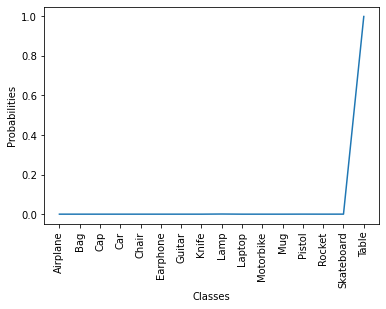

KeyboardInterrupt: Interrupted by user

In [60]:
# Three.js based visualizer
visualizer = JVisualizer()

# Basic inference and visualization loop
MAX_SAMPLES = 15
for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    visualizer.clear()
    clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    visualizer.add_geometry(cloud)
    visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))
    